In [1]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

In [2]:
client = InfluxDBClient(host='140.112.42.160', port=23234, database='test_2')

In [3]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'west-eu': 'Europe',
        'west-us': 'West US',
    }

In [4]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def mean(l):
    return sum(l)/len(l)

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

Observe the lifetime of servers

In [5]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
sample_time1 = ['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00']
sample_time2 = ['01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00', '23:59:59']

In [6]:
st = f'2019-10-28T00:00:00Z' 
et = f'2019-11-10T23:59:59Z'
q = build_query(st, et, loc='west-us', lang=None)
result = client.query(q)
server_set, _ = get_edge_num(result)
server_list = list(server_set)
print(len(server_set))
print(len(server_list))

197
197


In [7]:
server_lifetime_table = np.zeros((len(server_list), len(date)*len(sample_time1)), dtype=int)
server_number_per_hour = np.zeros((len(date)*len(sample_time1),), dtype=int)
print(server_lifetime_table.shape)
for i, dat in enumerate(date):
    for j, (t1, t2) in enumerate(zip(sample_time1, sample_time2)):
        st = f'2019-{dat}T{t1}Z'
        et = f'2019-{dat}T{t2}Z'
        q = build_query(st, et, loc='west-us', lang=None)
        result = client.query(q)
        server_set, _ = get_edge_num(result)
        print(dat, t1, t2, server_set)
        server_number_per_hour[i*24+j] = len(server_set)
        for k, server in enumerate(server_list):
            if server in server_set:
                server_lifetime_table[k, i*24+j] = 1
print(server_lifetime_table)

(197, 336)
10-28 00:00:00 01:00:00 {'52.223.227.248', '52.223.247.39', '52.223.247.46', '52.223.247.243', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '99.181.96.122', '52.223.228.122', '52.223.228.52', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '99.181.96.125', '52.223.247.93', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.229', '52.223.247.152', '52.223.247.43', '52.223.228.102', '52.223.247.185', '99.181.96.118', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.228.106', '52.223.247.76', '52.223.227.240', '99.181.96.111', '99.181.96.134', '52.223.227.234', '99.181.96.189', '99.181.96.100', '52.223.227.230', '52.223.228.107', '52.223.247.77', '99.181.96.108', '52.223.228.26', '52.223.227.232', '52.223.228.10', '52.223.247.170', '52.223.228.18', '52.223.228.89', '52.223.228.

10-28 08:00:00 09:00:00 {'52.223.227.243', '99.181.96.108', '52.223.228.26', '52.223.227.248', '52.223.227.232', '52.223.228.68', '52.223.228.10', '99.181.96.118', '52.223.228.93', '52.223.228.18', '52.223.228.89', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.109', '99.181.96.135', '52.223.228.24', '52.223.228.4', '99.181.96.167', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '99.181.96.164', '52.223.228.40', '52.223.228.37', '52.223.228.122', '99.181.96.122', '52.223.228.52', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '99.181.96.162', '52.223.228.103', '52.223.228.95', '99.181.96.115', '99.181.96.111', '52.223.228.92', '52.223.228.9', '99.181.96.134', '99.181.96.126', '52.223.228.118', '99.181.96.189', '52.223.227.234', '99.181.96.110', '99.181.96.120', '99.181.96.100', '52.223.227.219', '52.223.228.8', '52.223.227.230', '99.181.96.125', '52.223.227.241', '99.181.96.112', '52.223.225.214

10-28 15:00:00 16:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.122', '52.223.228.52', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.228.118', '52.223.227.241', '52.223.227.234', '52.223.228.8', '52.223.227.219', '52.223.227.230', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.226.26', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
10-28 16:00:00 17:00:00 {'52.223.227.248', '52.223.247.46', '52.223.247.243', '52.223.228.68', '52.223.247.169', '

10-28 23:00:00 23:59:59 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.247.170', '52.223.228.93', '52.223.228.18', '52.223.228.89', '99.181.96.118', '52.223.228.97', '52.223.228.29', '99.181.96.109', '99.181.96.135', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '99.181.96.164', '52.223.247.43', '52.223.228.40', '52.223.228.37', '52.223.247.86', '52.223.247.72', '52.223.247.160', '52.223.228.52', '52.223.228.122', '52.223.247.63', '99.181.96.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '99.181.96.162', '52.223.228.103', '52.223.228.95', '52.223.247.211', '99.181.96.111', '99.181.96.126', '52.223.228.92', '52.223.228.9', '99.181.96.134', '99.181.96.115', '99.181.96.110', '52.223.228.118', '52.223.227.241', '52.223.228.8', '52.223.227.219', '52.223.227.230', '52.223.227.234', '99.181.96.189', '99.181.96.1

10-29 06:00:00 07:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.228.18', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.227.241', '52.223.228.118', '52.223.227.234', '52.223.227.219', '52.223.228.8', '52.223.227.230', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
10-29 07:00:00 08:00:00 {'52.223.247.40', '52.223.247.243', '52.223.227.248', '52.223.247.46', '52.223.247.39', '5

10-29 13:00:00 14:00:00 {'52.223.247.40', '52.223.247.243', '52.223.247.39', '52.223.247.46', '52.223.227.248', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '52.223.228.122', '99.181.96.122', '52.223.247.99', '52.223.228.123', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '52.223.247.93', '99.181.96.112', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.236', '52.223.247.152', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.225.137', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.247.76', '52.223.227.240', '52.223.247.211', '52.223.225.159', '99.181.96.111', '99.181.96.134', '99.181.96.189', '52.223.227.234',

10-29 18:00:00 19:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.247.243', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.228.18', '52.223.228.93', '52.223.247.169', '52.223.228.89', '52.223.247.120', '52.223.228.97', '52.223.247.91', '52.223.228.29', '52.223.247.87', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.89', '52.223.247.86', '52.223.247.111', '52.223.247.160', '52.223.228.122', '52.223.247.63', '52.223.247.46', '52.223.228.52', '52.223.228.106', '52.223.247.165', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.247.211', '52.223.248.235', '52.223.228.92', '52.223.228.9', '52.223.247.73', '52.223.228.118', '52.223.227.234', '52.223.227.241', '52.223.227.219', '52.223.228.8', '52.223.227.230', '52.223.247.93', '52.223.247.233', '52.223.228.13', '52.2

10-30 03:00:00 04:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.227.241', '52.223.227.234', '52.223.228.118', '52.223.227.230', '52.223.227.219', '52.223.228.8', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
10-30 04:00:00 05:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '

10-30 10:00:00 11:00:00 {'52.223.247.40', '52.223.247.243', '52.223.227.248', '52.223.247.39', '52.223.247.46', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '99.181.96.122', '52.223.228.52', '52.223.228.122', '52.223.247.99', '52.223.228.123', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.229', '52.223.247.113', '52.223.247.236', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.247.76', '52.223.227.240', '99.181.96.111', '99.181.96.134', '52.223.227.234', '99.181.96.189', '99.181.96.100', '52.223.227.230', '52.223.228.107', '52.223.228.59', '

10-30 15:00:00 16:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.228.118', '52.223.227.234', '52.223.227.241', '52.223.228.8', '52.223.227.230', '52.223.227.219', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
10-30 16:00:00 17:00:00 {'52.223.247.40', '52.223.247.46', '52.223.247.39', '52.223.227.248', '52.223.247.243', '5

10-30 22:00:00 23:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.227.241', '52.223.227.234', '52.223.228.118', '52.223.227.230', '52.223.228.8', '52.223.227.219', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
10-30 23:00:00 23:59:59 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '

10-31 08:00:00 09:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.227.241', '52.223.228.118', '52.223.227.234', '52.223.227.219', '52.223.227.230', '52.223.228.8', '52.223.228.13', '52.223.228.30', '52.223.228.25', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
10-31 09:00:00 10:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '

10-31 14:00:00 15:00:00 {'52.223.247.40', '52.223.247.46', '52.223.227.248', '52.223.247.243', '52.223.247.39', '52.223.228.68', '52.223.247.169', '99.181.96.167', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.122', '99.181.96.122', '52.223.228.52', '52.223.247.99', '52.223.228.123', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '99.181.96.112', '99.181.96.106', '52.223.228.125', '52.223.247.95', '52.223.247.152', '52.223.228.49', '52.223.228.102', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.228.40', '52.223.228.37', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.211', '99.181.96.111', '99.181.96.134', '99.181.96.189', '52.223.227.234', '99.181.96.100', '52.223.227.230', '52.223.247.237', '52.223.228.107', '52.223.228.59', '52.223.247.77', '99.181.96.108', '52.223.228.26', '52.223.227.232', '52.223.228.10', '52.223.228.18', '52.2

10-31 22:00:00 23:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '99.181.96.108', '52.223.227.232', '52.223.228.68', '99.181.96.118', '52.223.228.10', '52.223.228.93', '52.223.228.18', '52.223.228.89', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '99.181.96.164', '52.223.228.40', '52.223.228.37', '52.223.228.122', '52.223.228.52', '99.181.96.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '99.181.96.111', '99.181.96.126', '52.223.228.92', '52.223.228.9', '99.181.96.134', '52.223.227.234', '52.223.228.118', '52.223.227.241', '52.223.228.8', '52.223.227.230', '52.223.227.219', '99.181.96.189', '99.181.96.125', '99.181.96.112', '52.223.228.13', '52.223.228.30', '52.223.228.25', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.2

11-01 06:00:00 07:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '99.181.96.108', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '99.181.96.118', '52.223.228.93', '52.223.228.89', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.100', '99.181.96.109', '99.181.96.135', '52.223.228.24', '52.223.228.4', '99.181.96.167', '52.223.247.178', '52.223.228.94', '52.223.228.5', '52.223.228.99', '99.181.96.164', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.247.89', '99.181.96.122', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '99.181.96.163', '99.181.96.162', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '99.181.96.115', '99.181.96.126', '52.223.228.92', '52.223.228.9', '99.181.96.134', '99.181.96.111', '52.223.227.241', '52.223.227.234', '99.181.96.189', '99.181.96.110', '52.223.228.8', '52.223.227.230', '99.181.96.120', '99.181.96.125', '52.223.227.219'

11-01 13:00:00 14:00:00 {'52.223.247.40', '52.223.227.248', '52.223.247.39', '52.223.247.46', '52.223.247.243', '52.223.228.68', '52.223.247.169', '99.181.96.167', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.247.160', '99.181.96.122', '52.223.228.52', '52.223.228.122', '52.223.247.99', '52.223.228.123', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '52.223.247.93', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.152', '52.223.247.236', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.185', '52.223.247.105', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '99.181.96.111', '99.181.96.134', '52.223.227.234', '99.181.96.189', '

11-01 20:00:00 21:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.227.234', '52.223.228.118', '52.223.227.241', '52.223.227.230', '52.223.228.8', '52.223.227.219', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
11-01 21:00:00 22:00:00 {'52.223.227.248', '52.223.247.39', '52.223.247.46', '52.223.247.243', '52.223.228.68', '5

11-02 04:00:00 05:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '99.181.96.108', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.228.18', '52.223.228.93', '52.223.247.46', '52.223.228.89', '52.223.228.97', '99.181.96.107', '52.223.228.29', '52.223.247.87', '99.181.96.109', '99.181.96.135', '52.223.228.24', '52.223.228.4', '99.181.96.167', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '99.181.96.120', '99.181.96.164', '52.223.228.40', '52.223.247.72', '52.223.228.37', '99.181.96.122', '52.223.228.52', '52.223.247.63', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '99.181.96.162', '52.223.228.90', '52.223.227.240', '52.223.228.103', '52.223.228.95', '99.181.96.115', '99.181.96.126', '52.223.228.92', '52.223.228.9', '99.181.96.134', '99.181.96.111', '52.223.247.38', '52.223.227.241', '52.223.227.234', '99.181.96.110', '99.181.96.100', '52.223.227.230', '52.223.227.219', '52.223.228.118', '99.181.96.125

11-02 10:00:00 11:00:00 {'52.223.247.40', '52.223.227.248', '52.223.247.39', '52.223.247.243', '52.223.247.46', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '99.181.96.122', '52.223.228.122', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.95', '52.223.247.113', '52.223.247.236', '52.223.247.152', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.185', '52.223.247.105', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.247.76', '52.223.227.240', '52.223.247.211', '99.181.96.111', '99.181.96.134', '99.181.96.189', '52.223.227.234', '99.181.96.100', '5

11-02 15:00:00 16:00:00 {'52.223.227.248', '52.223.247.46', '52.223.228.68', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '99.181.96.122', '52.223.228.122', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '99.181.96.125', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.113', '52.223.228.49', '52.223.228.102', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.228.106', '52.223.227.240', '52.223.247.76', '99.181.96.111', '99.181.96.134', '52.223.227.234', '99.181.96.189', '99.181.96.100', '52.223.227.230', '99.181.96.156', '52.223.247.237', '52.223.228.107', '52.223.247.77', '99.181.96.108', '52.223.228.26', '52.223.227.232', '52.223.228.18', '52.223.228.10', '52.223.228.89', '52.223.247.87', '52.223.228.24', '52.223.228.94', '99.181.96.164', '52.223.

11-02 21:00:00 22:00:00 {'52.223.247.40', '52.223.227.248', '52.223.247.46', '52.223.228.68', '52.223.247.169', '99.181.96.167', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.122', '99.181.96.122', '52.223.228.52', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '52.223.247.93', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.229', '52.223.247.113', '52.223.247.236', '52.223.247.152', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.228.106', '52.223.227.240', '52.223.247.211', '99.181.96.111', '99.181.96.134', '99.181.96.189', '52.223.227.234', '99.181.96.100', '52.223.227.230', '52.223.228.107', '52.223.247.77', '99.181.96.108', '

11-03 02:00:00 03:00:00 {'52.223.247.40', '52.223.227.248', '52.223.247.39', '52.223.247.46', '52.223.247.243', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '99.181.96.122', '52.223.228.122', '52.223.228.52', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '52.223.247.93', '99.181.96.112', '99.181.96.106', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.236', '52.223.247.152', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '99.181.96.111', '99.181.96.134', '99.181.96.189', '52.223.227.234', '9

11-03 07:00:00 08:00:00 {'52.223.247.40', '52.223.247.243', '52.223.247.39', '52.223.227.248', '52.223.247.46', '52.223.228.68', '52.223.247.169', '99.181.96.167', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '99.181.96.122', '52.223.228.122', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '52.223.247.93', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.236', '52.223.247.152', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.185', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '99.181.96.111', '99.181.96.134', '52.223.227.234', '99.181.96.100', '52.223.227.230', '99.181.96.156', '

11-03 12:00:00 13:00:00 {'52.223.247.40', '52.223.247.46', '52.223.227.248', '52.223.247.243', '52.223.247.39', '52.223.228.68', '52.223.247.169', '99.181.96.167', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.122', '99.181.96.122', '52.223.228.52', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '52.223.247.93', '99.181.96.112', '99.181.96.106', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.152', '52.223.247.236', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '99.181.96.111', '99.181.96.134', '99.181.96.189', '52.223.227.234', '

11-03 17:00:00 18:00:00 {'52.223.247.40', '52.223.227.248', '52.223.247.39', '52.223.247.46', '52.223.247.243', '52.223.228.68', '52.223.247.169', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '52.223.228.122', '52.223.247.99', '52.223.228.123', '52.223.247.101', '52.223.228.95', '52.223.247.93', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.236', '52.223.247.152', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '52.223.247.112', '52.223.228.97', '52.223.228.29', '52.223.228.40', '52.223.228.37', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '52.223.227.234', '52.223.227.230', '52.223.247.237', '52.223.228.107', '52.223.247.77', '52.223.228.26', '52.223.227.232', '52.223.228.18', '52.223.228.10', '52.223.247.170', '52.223.228.89', '52.223.228.24', '52.223.228.94', '52.223.247.146', '52.223.247.89', '52.223.228.85', '52.223.228.90', '52.223.228.103'

11-03 23:00:00 23:59:59 {'52.223.227.248', '52.223.247.46', '52.223.228.68', '52.223.228.4', '52.223.228.5', '52.223.247.160', '52.223.228.52', '52.223.228.122', '99.181.96.122', '52.223.247.99', '52.223.228.123', '52.223.247.101', '52.223.228.95', '99.181.96.120', '99.181.96.125', '52.223.247.93', '99.181.96.112', '52.223.228.125', '52.223.247.95', '52.223.228.49', '52.223.228.102', '52.223.247.105', '99.181.96.118', '52.223.247.120', '52.223.228.97', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.228.106', '52.223.227.240', '99.181.96.111', '99.181.96.134', '52.223.227.234', '99.181.96.189', '99.181.96.100', '52.223.227.230', '99.181.96.156', '52.223.247.237', '52.223.228.107', '52.223.228.59', '99.181.96.108', '52.223.228.26', '52.223.227.232', '52.223.228.18', '52.223.228.10', '52.223.228.89', '52.223.228.24', '52.223.228.94', '52.223.247.146', '99.181.96.164', '52.223.247.89', '52.223.228.85', '99.181.96.162', '52.223.228.90', '52.223

11-04 06:00:00 07:00:00 {'52.223.227.248', '52.223.247.46', '52.223.247.243', '52.223.228.68', '52.223.247.169', '99.181.96.167', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.122', '52.223.228.52', '99.181.96.122', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.152', '52.223.247.236', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.185', '52.223.247.105', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '52.223.228.29', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '99.181.96.134', '52.223.227.234', '99.181.96.189', '99.181.96.100', '52.223.227.230', '52.223.247.237', '52.223.228.107', '52.223.228.26', '52.223.227.232

11-04 11:00:00 12:00:00 {'52.223.247.243', '52.223.247.46', '52.223.227.248', '52.223.247.39', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.122', '99.181.96.122', '52.223.225.175', '52.223.228.52', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '52.223.247.93', '99.181.96.125', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.95', '52.223.247.152', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.185', '52.223.247.105', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '99.181.96.111', '99.181.96.134', '99.181.96.189', '52.223.227.234', '99.181.96.100', '52.223.227.230', '99.181.96.156', '5

11-04 17:00:00 18:00:00 {'52.223.247.40', '52.223.247.46', '52.223.227.248', '52.223.247.39', '52.223.247.243', '52.223.228.68', '52.223.247.169', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '52.223.228.122', '52.223.247.99', '52.223.228.123', '52.223.247.101', '52.223.228.95', '52.223.247.208', '52.223.247.93', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.152', '52.223.247.236', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.185', '52.223.247.105', '52.223.247.120', '52.223.228.97', '52.223.228.29', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.211', '52.223.227.234', '52.223.227.230', '52.223.247.237', '52.223.228.107', '52.223.247.77', '52.223.228.26', '52.223.227.232', '52.223.228.10', '52.223.247.170', '52.223.228.18', '52.223.228.89', '52.223.247.87', '52.223.228.24', '52.223.228.94', '52.223.247.14

11-05 00:00:00 01:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.228.18', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.227.241', '52.223.228.118', '52.223.227.234', '52.223.227.230', '52.223.228.8', '52.223.227.219', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
11-05 01:00:00 02:00:00 {'52.223.227.243', '99.181.96.108', '52.223.228.26', '52.223.227.232', '52.223.228.68', '5

11-05 08:00:00 09:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.227.241', '52.223.227.234', '52.223.228.118', '52.223.228.8', '52.223.227.219', '52.223.227.230', '52.223.228.13', '52.223.228.30', '52.223.228.25', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
11-05 09:00:00 10:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '

11-05 14:00:00 15:00:00 {'52.223.227.243', '99.181.96.108', '52.223.228.26', '52.223.227.248', '52.223.227.232', '52.223.228.68', '52.223.228.18', '99.181.96.118', '52.223.228.93', '52.223.228.10', '52.223.228.89', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.109', '99.181.96.135', '52.223.228.24', '52.223.228.4', '99.181.96.167', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '99.181.96.164', '99.181.96.120', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '99.181.96.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '99.181.96.163', '52.223.227.240', '99.181.96.162', '52.223.228.90', '52.223.228.103', '52.223.228.95', '99.181.96.115', '99.181.96.126', '52.223.228.92', '52.223.228.9', '99.181.96.134', '99.181.96.111', '52.223.227.234', '99.181.96.189', '52.223.227.241', '52.223.227.219', '52.223.227.230', '99.181.96.156', '99.181.96.110', '52.223.228.118', '99.181.96.100', '99.181.96.125', '99.181.96.112

11-05 21:00:00 22:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.228.118', '52.223.227.234', '52.223.227.241', '52.223.227.230', '52.223.227.219', '52.223.228.8', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
11-05 22:00:00 23:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '99.181.96.108', '52.223.227.232', '

11-06 06:00:00 07:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.228.118', '52.223.227.241', '52.223.227.234', '52.223.228.8', '52.223.227.230', '52.223.227.219', '52.223.228.13', '52.223.228.30', '52.223.228.25', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
11-06 07:00:00 08:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '

11-06 13:00:00 14:00:00 {'52.223.227.248', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.228.52', '52.223.228.122', '99.181.96.122', '52.223.228.123', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.229', '52.223.247.152', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.185', '52.223.247.112', '99.181.96.118', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.247.76', '52.223.227.240', '99.181.96.111', '99.181.96.134', '99.181.96.189', '52.223.227.234', '99.181.96.100', '52.223.227.230', '99.181.96.156', '52.223.228.107', '52.223.228.59', '99.181.96.108', '52.223.228.26', '52.223.227.232', '52.223.228.18', '52.223.228.10', '52.223.228.89', '52.223.228.24', '52.223.228.94', '52.223.247.146', '99.181.96.164', '52.2

11-06 18:00:00 19:00:00 {'52.223.247.40', '52.223.227.248', '52.223.247.243', '52.223.247.46', '52.223.247.39', '52.223.228.68', '52.223.247.169', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '52.223.228.122', '52.223.247.99', '52.223.228.123', '52.223.247.101', '52.223.228.95', '52.223.247.208', '52.223.247.93', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.152', '52.223.247.236', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '52.223.247.112', '52.223.247.120', '52.223.228.97', '52.223.228.29', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '52.223.227.234', '52.223.227.230', '52.223.247.237', '52.223.228.107', '52.223.247.77', '52.223.228.26', '52.223.227.232', '52.223.228.18', '52.223.247.170', '52.223.228.10', '52.223.228.89', '52.223.247.87', '52.223.228.2

11-07 04:00:00 05:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.18', '52.223.228.10', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.227.234', '52.223.228.118', '52.223.227.241', '52.223.228.8', '52.223.227.230', '52.223.227.219', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
11-07 05:00:00 06:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '

11-07 12:00:00 13:00:00 {'52.223.247.40', '52.223.247.46', '52.223.227.248', '52.223.247.39', '52.223.247.243', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '99.181.96.122', '52.223.228.122', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '52.223.247.93', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.236', '52.223.247.152', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.247.76', '52.223.227.240', '52.223.247.211', '99.181.96.111', '99.181.96.134', '99.181.96.189', '5

11-07 17:00:00 18:00:00 {'52.223.227.248', '52.223.247.243', '52.223.247.46', '52.223.228.68', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '52.223.228.122', '99.181.96.122', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '52.223.247.93', '99.181.96.112', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.236', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.247.76', '52.223.227.240', '52.223.247.211', '99.181.96.111', '99.181.96.134', '52.223.227.234', '52.223.227.230', '99.181.96.156', '52.223.247.237', '52.223.228.107', '52.223.247.77', '99.181.96.108', '

11-08 01:00:00 02:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.228.18', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.9', '52.223.227.241', '52.223.227.234', '52.223.228.118', '52.223.228.8', '52.223.227.230', '52.223.227.219', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
11-08 02:00:00 03:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.10', '

11-08 09:00:00 10:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.228.18', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.228.118', '52.223.227.241', '52.223.227.234', '52.223.227.219', '52.223.228.8', '52.223.227.230', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
11-08 10:00:00 11:00:00 {'52.223.227.243', '52.223.227.248', '99.181.96.108', '52.223.228.26', '52.223.227.232', '

11-08 14:00:00 15:00:00 {'52.223.247.40', '52.223.227.248', '52.223.247.39', '52.223.247.46', '52.223.247.243', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.122', '99.181.96.122', '52.223.228.52', '52.223.247.99', '52.223.228.123', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '52.223.247.93', '99.181.96.125', '99.181.96.112', '52.223.228.125', '99.181.96.106', '52.223.247.229', '52.223.247.95', '52.223.247.152', '52.223.247.236', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.185', '52.223.247.105', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '99.181.96.111', '99.181.96.134', '52.223.227.234', '99.181.96.189', '99.181.96.100', '52.223.227.230', '9

11-09 03:00:00 04:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.228.18', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.247.91', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.247.178', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.247.86', '52.223.228.122', '52.223.228.52', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.247.38', '52.223.247.73', '52.223.227.234', '52.223.227.241', '52.223.228.118', '52.223.227.219', '52.223.228.8', '52.223.227.230', '52.223.247.233', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.247.119', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.247.42', '52.223.247.236', '52.223.247.43', '52.223.228.49', '52.223.2

11-09 08:00:00 09:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.228.18', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.247.91', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.247.178', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.228.52', '52.223.228.122', '52.223.228.106', '52.223.247.99', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.228.118', '52.223.227.241', '52.223.227.234', '52.223.227.230', '52.223.228.8', '52.223.227.219', '52.223.247.233', '52.223.228.13', '52.223.228.30', '52.223.228.25', '52.223.228.125', '52.223.247.119', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.247.42', '52.223.247.236', '52.223.247.43', '52.223.228.49', '52.223.228.59', '52.223.

11-09 14:00:00 15:00:00 {'52.223.247.40', '52.223.247.243', '52.223.247.39', '52.223.227.248', '52.223.247.46', '52.223.228.68', '52.223.247.169', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.228.52', '52.223.228.122', '52.223.247.99', '52.223.228.123', '52.223.247.101', '52.223.228.95', '52.223.247.208', '52.223.247.93', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.236', '52.223.247.152', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.185', '52.223.247.105', '52.223.247.120', '52.223.228.97', '52.223.228.29', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.227.234', '52.223.227.230', '52.223.247.237', '52.223.228.107', '52.223.247.77', '52.223.228.26', '52.223.227.232', '52.223.247.170', '52.223.228.18', '52.223.228.10', '52.223.228.89', '52.223.247.87', '52.223.228.24', '52.223.228.94', '52.223.247.146', '52.223.247.89'

11-09 19:00:00 20:00:00 {'52.223.227.243', '52.223.227.248', '52.223.228.26', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.228.18', '52.223.228.93', '52.223.228.89', '52.223.228.97', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.40', '52.223.228.37', '52.223.228.122', '52.223.228.52', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.228.92', '52.223.228.9', '52.223.228.118', '52.223.227.234', '52.223.227.241', '52.223.227.230', '52.223.228.8', '52.223.227.219', '52.223.228.13', '52.223.228.25', '52.223.228.30', '52.223.228.125', '52.223.228.96', '52.223.228.98', '52.223.228.107', '52.223.228.28', '52.223.228.49', '52.223.228.59', '52.223.228.102', '52.223.228.87', '52.223.228.27'}
11-09 20:00:00 21:00:00 {'52.223.227.243', '99.181.96.108', '52.223.228.26', '52.223.227.248', '52.223.227.232', '

11-10 02:00:00 03:00:00 {'52.223.247.40', '52.223.227.248', '52.223.247.39', '52.223.247.46', '52.223.247.243', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '52.223.228.122', '99.181.96.122', '52.223.247.99', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '52.223.247.93', '99.181.96.125', '99.181.96.112', '99.181.96.106', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.113', '52.223.247.236', '52.223.247.152', '52.223.247.43', '52.223.228.49', '52.223.228.102', '52.223.247.185', '52.223.247.105', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.247.167', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.247.76', '52.223.227.240', '52.223.247.211', '99.181.96.111', '99.181.96.134', '52.223.227.234', '

11-10 08:00:00 09:00:00 {'52.223.247.40', '52.223.227.248', '52.223.247.39', '52.223.247.243', '52.223.247.46', '52.223.228.68', '52.223.247.169', '52.223.228.4', '99.181.96.167', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '52.223.228.122', '99.181.96.122', '52.223.247.99', '52.223.228.123', '52.223.228.95', '99.181.96.120', '52.223.247.208', '52.223.247.93', '99.181.96.112', '52.223.228.125', '52.223.247.229', '52.223.247.113', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.247.63', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '52.223.227.234', '99.181.96.189', '99.181.96.100', '52.223.227.230', '99.181.96.156', '52.223.228.107', '52.223.228.59', '52.223.247.77', '99.181.96.108', '52.223.228.26', '52.223.227.232', '52.223.228.18', '52.223.247.170', '

11-10 13:00:00 14:00:00 {'52.223.247.40', '52.223.227.248', '52.223.247.39', '52.223.247.46', '52.223.228.68', '52.223.247.169', '99.181.96.167', '52.223.228.4', '52.223.228.5', '52.223.247.86', '52.223.247.160', '52.223.228.52', '52.223.228.122', '99.181.96.122', '52.223.228.123', '99.181.96.163', '52.223.247.101', '52.223.228.95', '99.181.96.120', '52.223.247.208', '99.181.96.125', '99.181.96.112', '99.181.96.106', '52.223.228.125', '52.223.247.229', '52.223.247.95', '52.223.247.236', '52.223.228.49', '52.223.228.102', '52.223.247.105', '52.223.247.185', '52.223.247.112', '99.181.96.118', '52.223.247.120', '52.223.228.97', '99.181.96.107', '52.223.228.29', '99.181.96.135', '52.223.228.40', '52.223.228.37', '52.223.247.111', '52.223.228.106', '52.223.227.240', '52.223.247.76', '52.223.247.211', '99.181.96.111', '99.181.96.134', '52.223.227.234', '99.181.96.189', '99.181.96.100', '52.223.227.230', '99.181.96.156', '52.223.247.237', '52.223.228.107', '99.181.96.108', '52.223.228.26', '5

11-10 18:00:00 19:00:00 {'52.223.247.112', '52.223.227.248', '52.223.228.26', '52.223.227.243', '52.223.227.232', '52.223.228.68', '52.223.228.10', '52.223.228.18', '52.223.228.93', '52.223.247.77', '52.223.228.89', '52.223.247.120', '52.223.228.97', '52.223.247.91', '52.223.228.29', '52.223.228.24', '52.223.228.4', '52.223.228.94', '52.223.228.5', '52.223.228.99', '52.223.228.17', '52.223.228.102', '52.223.228.40', '52.223.228.37', '52.223.247.89', '52.223.228.122', '52.223.228.52', '52.223.247.165', '52.223.228.106', '52.223.228.123', '52.223.228.7', '52.223.228.85', '52.223.227.240', '52.223.228.90', '52.223.228.103', '52.223.228.95', '52.223.247.101', '52.223.247.211', '52.223.228.92', '52.223.228.9', '52.223.247.38', '52.223.228.118', '52.223.227.234', '52.223.227.241', '52.223.228.8', '52.223.227.230', '52.223.227.219', '52.223.247.208', '52.223.247.233', '52.223.228.13', '52.223.228.30', '52.223.247.33', '52.223.228.125', '52.223.228.25', '52.223.247.171', '52.223.228.96', '52.2

In [8]:
accumulation = np.zeros((2, 24))
for i in range(24):
    accumulation[0, i] = i
    accumulation[1, i] = np.sum(server_number_per_hour[i:264:24])/11
print(accumulation)

[[  0.           1.           2.           3.           4.
    5.           6.           7.           8.           9.
   10.          11.          12.          13.          14.
   15.          16.          17.          18.          19.
   20.          21.          22.          23.        ]
 [ 65.72727273  64.          64.09090909  61.09090909  59.
   64.72727273  69.36363636  79.09090909  82.63636364  75.81818182
   85.54545455  85.45454545 110.63636364 115.90909091  98.45454545
   68.81818182  73.27272727  88.09090909  80.45454545  54.81818182
   60.72727273  63.09090909  67.54545455  62.36363636]]


Baseline

In [9]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
date_1 = ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11']

In [10]:
BS_24hr_12am = np.zeros((len(date),), dtype = int)
BS_24hr_12am_tran = np.zeros((len(date),), dtype = int)

In [11]:
def get_server_ip_bs(d1, d2, t1, t2, loc, lang=None):
    st = f'2019-{d1}T{t1}:00:00Z' 
    et = f'2019-{d2}T{t2}:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    BS, BS_t = get_edge_num(result)
    return len(BS), BS_t


In [12]:
#24hr-baseline
for d, (date1, date2) in enumerate(zip(date, date_1)):
    num, tran = get_server_ip_bs(date1, date2, "00", "00", 'west-us')
    BS_24hr_12am[d] = num
    BS_24hr_12am_tran[d] = tran

print(BS_24hr_12am)
print(BS_24hr_12am_tran)

[131 135 131 132 141 128 152 133 140 152 128 130 131 129]
[331715 363885 341492 320152 327913 315358 291054 320451 317502 278662
 284515 212132 260809 264912]


CJS model -- 24 hr -- 12am

In [13]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']

In [14]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [15]:
def get_server_ip_sampling(date, t1, t2, idx, loc, lang=None):
    
    c_st = f'2019-{date}T{t1}Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    last_rec = np.zeros((idx,), dtype = int)
    marked_sum = 0
    if idx > 0:
        for server in C:
            for d, server_cluster in enumerate(record_server_table[::-1]):
                if server in server_cluster:
                    last_rec[d] += 1
                    marked_sum += 1
                    break
        last_capture_table[idx, :idx] = last_rec[::-1]
        
    m_t[idx] = marked_sum
    u_t[idx] = len(C)-marked_sum
    n_t[idx] = len(C)
    record_server_table.append(C)
    C_tran[idx] = C_t

In [16]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", j, 'west-us')

CNt_24hr_12am = n_t
CMt_24hr_12am = m_t
R_t_24hr_12am, Z_t_24hr_12am = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12am/(R_t_24hr_12am+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12am = N_t
C_tran_24hr_12am = C_tran
print(estimate_N_24hr_12am)

[  0.         126.79054054 108.         111.27720108 112.43076923
 100.         113.4765625   65.3046875   50.          50.
  50.          50.          50.          50.        ]


CJS model -- 24 hr -- 4am

In [17]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [18]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "05:00:00", j, 'west-us')

CNt_24hr_4am = n_t
CMt_24hr_4am = m_t
R_t_24hr_4am, Z_t_24hr_4am = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_4am[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_4am[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_4am/(R_t_24hr_4am+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_4am = N_t
C_tran_24hr_4am = C_tran
print(estimate_N_24hr_4am)

[ 0.         75.34901961 78.23076923 74.         74.         85.67444444
 77.         78.71377368 78.00999616 76.         76.         76.
 89.81818182 57.        ]


CJS model -- 24 hr -- 8am

In [19]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [20]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "08:00:00", "09:00:00", j, 'west-us')

CNt_24hr_8am = n_t
CMt_24hr_8am = m_t
R_t_24hr_8am, Z_t_24hr_8am = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_8am[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_8am[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_8am/(R_t_24hr_8am+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_8am = N_t
C_tran_24hr_8am = C_tran
print(estimate_N_24hr_8am)

[  0.          74.46       121.02748126 119.         123.10344828
 128.48209524 127.947404   126.         126.         126.
 126.54545455 122.37755102 108.47368421 103.        ]


CJS model -- 24 hr -- 12pm

In [21]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [22]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "12:00:00", "13:00:00", j, 'west-us')

CNt_24hr_12pm = n_t
CMt_24hr_12pm = m_t
R_t_24hr_12pm, Z_t_24hr_12pm = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12pm/(R_t_24hr_12pm+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm = N_t
C_tran_24hr_12pm = C_tran
print(estimate_N_24hr_12pm)

[  0.         126.         126.         126.         126.95861592
 126.15740741 126.         126.         126.         128.0814256
 126.         126.         116.97752809 104.        ]


CJS model -- 24 hr -- 4pm

In [23]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [24]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "16:00:00", "17:00:00", j, 'west-us')

CNt_24hr_4pm = n_t
CMt_24hr_4pm = m_t
R_t_24hr_4pm, Z_t_24hr_4pm = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_4pm[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_4pm[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_4pm/(R_t_24hr_4pm+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_4pm = N_t
C_tran_24hr_4pm = C_tran
print(estimate_N_24hr_4pm)

[  0.         130.47761194 124.95867769 124.         127.91080354
 124.         126.4685571  127.95181406 124.         127.91080354
 124.44186047 126.87120338 124.24195122 100.        ]


CJS model -- 24 hr -- 8pm

In [25]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [26]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "20:00:00", "21:00:00", j, 'west-us')

CNt_24hr_8pm = n_t
CMt_24hr_8pm = m_t
R_t_24hr_8pm, Z_t_24hr_8pm = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_8pm[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_8pm[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_8pm/(R_t_24hr_8pm+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_8pm = N_t
C_tran_24hr_8pm = C_tran
print(estimate_N_24hr_8pm)

[  0.          69.36        69.          69.          69.
 124.2        109.2745098   73.          73.          73.
  73.          73.          74.97297297  50.        ]


CJS model -- 8 hr -- 12am

In [27]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [28]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_60min = N_t
C_tran_8hr_12am_60min = C_tran
print(estimate_N_8hr_12am_60min)

[  0.         103.39726027 112.47126437 125.4375     119.
 125.76136364 124.         128.37836673 126.         129.99000384
 126.         126.         126.         126.         129.99000384
 126.         127.2        127.         127.         128.97079502
 129.55246914 128.984375   128.         130.56582633 127.
 127.         127.         127.         127.         131.029604
 127.         127.         127.         127.         127.
 128.49019608 126.         127.13559322 125.11965812 118.
 121.13953488 100.        ]


In [29]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [30]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:50:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:50:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:50:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_50min = N_t
C_tran_8hr_12am_50min = C_tran
print(estimate_N_8hr_12am_50min)

[  0.         103.39726027 109.4375     127.36956522 119.
 125.76136364 124.         128.7669832  126.         129.99000384
 126.         126.         126.         126.         129.99000384
 126.         127.51807229 127.         127.         128.97079502
 127.         129.59183673 128.         133.53921569 127.
 127.         127.         127.         127.         131.029604
 127.         127.34821429 124.         124.         124.21621622
 123.39215686 121.         121.         121.57       118.
 121.57142857  98.        ]


In [31]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [32]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:40:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:40:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:40:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_40min = N_t
C_tran_8hr_12am_40min = C_tran
print(estimate_N_8hr_12am_40min)

[  0.         103.45714286 103.         108.22117647 104.
 116.48       113.         117.16435354 126.         129.99000384
 126.         126.         126.         126.         129.99000384
 126.         127.51807229 127.         127.         129.11659726
 127.         129.59183673 128.         133.53921569 127.
 127.         127.         127.         127.         131.029604
 127.         127.34821429 124.         124.         124.21621622
 123.39215686 121.         121.         121.57       118.
 121.57142857  98.        ]


In [33]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [34]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:30:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:30:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:30:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_30min = N_t
C_tran_8hr_12am_30min = C_tran
print(estimate_N_8hr_12am_30min)

[  0.          73.16481876  72.          73.9092      73.44
 120.23529412 106.         108.00714144 125.         125.
 125.         125.         125.         125.         128.95040369
 125.         127.45098039 126.         126.         127.7027027
 127.         127.         127.49411765 134.03844675 126.
 126.         126.         126.         126.         126.
 126.         127.14285714 116.         116.         116.
 117.2745098  115.         115.         115.52525253 111.
 114.5         98.        ]


In [35]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [36]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:20:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:20:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:20:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_20min = N_t
C_tran_8hr_12am_20min = C_tran
print(estimate_N_8hr_12am_20min)

[  0.          73.32420814  72.          73.9092      73.44
 115.94117647 103.         103.         125.         125.
 125.         125.         125.         125.         128.95040369
 125.         128.95040369 125.         125.         126.68918919
 126.         126.         126.48235294 132.95847751 125.
 125.         125.         125.         125.         125.
 125.         126.65       110.         110.         110.
 110.         110.         110.         110.76744186 107.
 110.09090909  93.        ]


In [37]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [38]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:10:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:10:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:10:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_10min = N_t
C_tran_8hr_12am_10min = C_tran
print(estimate_N_8hr_12am_10min)

[  0.          74.82926829  72.9787234   72.          73.5
  73.          73.          73.         125.         125.
 125.         125.         125.         125.         128.95040369
 125.         125.         125.         125.         125.
 125.         125.         136.74557052 116.75893887 110.
 110.         110.         110.         110.         110.
 110.         110.         110.         110.         110.
 110.         110.         110.         110.76744186 107.
 110.6         92.        ]


In [39]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [40]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:05:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:05:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:05:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_5min = N_t
C_tran_8hr_12am_5min = C_tran
print(estimate_N_8hr_12am_5min)

[  0.          71.96875     77.12820513  72.          72.
  73.56521739  73.          73.          73.          73.
  73.          73.          73.          73.          74.9496
  73.          73.          73.          73.          73.
  73.          73.          86.86571842  69.3472      66.
  66.          66.          66.          66.          66.
  66.          66.          66.          66.          66.
  66.          66.          66.         108.13186813  84.
  88.1         87.90123457]


In [41]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [42]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:01:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:01:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:01:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_1min = N_t
C_tran_8hr_12am_1min = C_tran
print(estimate_N_8hr_12am_1min)

[  0.          14.          84.          56.66666667  61.17647059
  58.8         53.          53.          54.89285714  57.6
  55.          55.          55.          55.          55.
  55.          55.          55.          75.25274725  56.
  56.          56.         102.8625      52.          52.
  52.          52.          52.          56.          50.
  53.16666667  50.33333333  49.4         52.71428571  47.55555556
  48.78947368  42.          42.         127.05050505  57.63636364
  77.29100529  44.51612903]


CJS model -- 8 hr -- 2am

In [43]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [44]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "03:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "11:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "19:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_60min = N_t
C_tran_8hr_2am_60min = C_tran
print(estimate_N_8hr_2am_60min)

[  0.          66.64        71.92647059 115.32427184 110.
 124.51417365 118.         123.31531532 126.36986301 125.
 125.         125.         125.         125.         125.
 125.         127.03252033 128.29591837 128.         128.
 128.         128.         128.         130.48543689 130.
 130.         140.96333573 127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.016
 128.9047619   65.        ]


In [45]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [46]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:50:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:50:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:50:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_50min = N_t
C_tran_8hr_2am_50min = C_tran
print(estimate_N_8hr_2am_50min)

[  0.          59.78        71.80327869 115.32427184 110.
 124.51417365 118.         123.31531532 126.36986301 125.
 125.         125.         125.         125.         125.
 125.         127.04918033 128.29591837 128.         128.
 128.         128.         128.         129.24271845 129.
 129.         141.49239788 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.9047619   65.        ]


In [47]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [48]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:40:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:40:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:40:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_40min = N_t
C_tran_8hr_2am_40min = C_tran
print(estimate_N_8hr_2am_40min)

[  0.          49.          69.58       113.86043689 109.
 118.57624633 113.         121.37037037 127.81690141 125.
 125.         125.         125.         125.         125.
 125.         126.28865979 128.65263158 128.         128.
 128.         128.         128.         129.31958763 129.
 129.         141.49239788 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.9047619   65.        ]


In [49]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [50]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:30:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:30:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:30:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_30min = N_t
C_tran_8hr_2am_30min = C_tran
print(estimate_N_8hr_2am_30min)

[  0.          49.          67.62       111.27077498 107.
 107.         107.         121.68627451 127.81690141 125.
 125.         125.         125.         125.         125.
 125.         126.37362637 128.65263158 128.         128.
 128.         128.         128.         129.47126437 129.
 129.         141.49239788 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.9047619   65.        ]


In [51]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [52]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:20:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:20:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:20:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_20min = N_t
C_tran_8hr_2am_20min = C_tran
print(estimate_N_8hr_2am_20min)

[  0.          49.          58.8        108.58998599 105.
 105.         105.         117.97752809 124.4057971  121.
 121.         121.         121.         121.         121.
 121.         121.         125.37349398 126.04958678 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         131.65853659
 110.         110.         110.         110.         110.
 110.         111.89285714 108.         108.         108.
 108.          51.        ]


In [53]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [54]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:10:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:10:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:10:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_10min = N_t
C_tran_8hr_2am_10min = C_tran
print(estimate_N_8hr_2am_10min)

[  0.          49.          49.          57.34042553  57.
  57.          57.          82.18604651  76.          76.
  76.          76.          76.          76.          76.
  84.76923077  82.         114.43318318 122.04177499 120.62162162
 119.         119.         126.57922629  93.          93.
  93.         107.41860465  73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          47.        ]


In [55]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [56]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:05:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:05:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:05:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_5min = N_t
C_tran_8hr_2am_5min = C_tran
print(estimate_N_8hr_2am_5min)

[  0.          47.55882353  49.26315789  50.58064516  50.
  50.          50.          85.71428571  65.          65.
  65.          65.          65.          65.          65.
  65.          65.          65.          70.          76.52510587
  67.          75.64516129 129.29287525  57.          57.
  57.          57.          57.          57.          57.
  57.          57.          57.          57.          57.
  57.          57.          57.          57.          61.15625
  50.42857143  35.        ]


In [57]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [58]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:01:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:01:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:01:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_1min = N_t
C_tran_8hr_2am_1min = C_tran
print(estimate_N_8hr_2am_1min)

[  0.          17.          53.83333333  49.09090909  37.
  46.25        40.          50.          49.63157895  50.625
  47.          56.4         50.          50.          50.
  50.          50.          50.         139.39393939  51.
  51.          51.          51.          51.          51.
  51.          51.          51.          51.          54.26315789
  49.          49.68965517  49.52631579  47.          47.
  47.          47.          48.9375      52.75       184.97142857
  53.15384615  21.        ]


CJS model -- 8 hr -- 4am

In [59]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [60]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_60min = N_t
C_tran_8hr_4am_60min = C_tran
print(estimate_N_8hr_4am_60min)

[  0.          72.98630137 100.74        95.68       126.
 126.         126.         126.         126.         126.
 126.         125.         125.         126.95861592 125.
 126.52439024 126.         126.         126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         128.0814256  126.
 126.         126.         126.         126.         126.
 119.         120.33333333 116.97752809 105.792      104.
 104.          50.        ]


In [61]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [62]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:50:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:50:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:50:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_50min = N_t
C_tran_8hr_4am_50min = C_tran
print(estimate_N_8hr_4am_50min)

[  0.          72.98630137  99.28        94.64       125.
 125.         125.         125.         125.         125.
 125.99206349 125.         125.         126.99404762 125.
 126.52439024 126.         126.         126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         128.0814256  126.
 126.         126.         125.         125.         125.3853211
 111.         112.22093023 108.09090909  84.25858291  83.
  83.          50.        ]


In [63]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [64]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:40:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:40:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:40:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_40min = N_t
C_tran_8hr_4am_40min = C_tran
print(estimate_N_8hr_4am_40min)

[  0.          72.98630137  80.3         81.12       106.66666667
 106.         108.         107.         107.         107.
 125.82407407 125.         125.         125.         125.
 125.         126.15740741 126.         126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         128.0814256  126.
 126.         126.         117.         117.         117.78787879
 111.         112.29411765 108.09090909  84.35469153  83.
  83.          50.        ]


In [65]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [66]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:30:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:30:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:30:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_30min = N_t
C_tran_8hr_4am_30min = C_tran
print(estimate_N_8hr_4am_30min)

[  0.          72.97222222  78.84        80.08       106.7012987
 106.         108.         107.         107.         107.
 125.82407407 125.         125.         125.         125.
 125.         126.37362637 126.         126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         128.10660897 125.
 125.         125.14678899 109.         109.         110.23595506
  98.          99.51948052  85.27631579  79.21285459  78.
  78.          50.        ]


In [67]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [68]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:20:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:20:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:20:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_20min = N_t
C_tran_8hr_4am_20min = C_tran
print(estimate_N_8hr_4am_20min)

[  0.          72.97222222  73.          75.92       104.39189189
 104.         105.96226415 105.         105.         105.
 123.76279577 122.         122.         122.         122.
 122.         123.69444444 126.04958678 126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         127.09049713 125.
 125.         125.84375     98.          98.          99.18421053
  93.          94.35135135  83.10666667  75.          75.
  75.          50.        ]


In [69]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [70]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:10:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:10:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:10:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_10min = N_t
C_tran_8hr_4am_10min = C_tran
print(estimate_N_8hr_4am_10min)

[  0.          72.97222222  73.          75.97959184  75.
  75.          79.41176471  78.          78.          78.
  78.05405405  77.          77.          77.          77.
  77.          78.18461538  78.          78.          78.
  78.          78.          79.04        79.          81.12879662
  79.          79.          79.         134.3237037   82.
  82.          82.          82.          82.          82.
  82.          89.30384615  74.          74.          74.
  75.59574468  49.        ]


In [71]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [72]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:05:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:05:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:05:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_5min = N_t
C_tran_8hr_4am_5min = C_tran
print(estimate_N_8hr_4am_5min)

[  0.          73.62068966  73.          75.97959184  75.
  75.          79.41176471  78.          78.          78.
  78.18181818  77.          77.          77.          77.
  77.          78.26229508  78.          78.          78.
  78.          78.          79.27868852  79.          81.12879662
  79.          79.          79.         210.68406126  81.
  81.          81.          81.          81.          81.
  81.          90.52631579  74.          74.          74.
  91.07692308  37.        ]


In [73]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [74]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:01:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:01:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:01:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_1min = N_t
C_tran_8hr_4am_1min = C_tran
print(estimate_N_8hr_4am_1min)

[  0.          87.13978495  62.9         63.4375      61.
  61.          65.20689655  77.          69.          69.
  76.88571429  73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          76.94888889
  76.35813149  73.          73.         271.24793388  73.
  73.          74.02777778  72.          74.89655172  75.16
  67.          67.          72.16129032  86.11111111  76.36363636
  99.          15.        ]


CJS model -- 8 hr -- 6am

In [75]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [76]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "07:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "15:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "23:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_60min = N_t
C_tran_8hr_6am_60min = C_tran
print(estimate_N_8hr_6am_60min)

[  0.          49.98       122.5        125.46       124.
 126.2962963  126.76056338 126.         126.         126.
 126.         126.         126.         126.         126.
 127.44827586 127.         127.         127.         127.
 127.         127.         128.3956044  128.         128.
 128.         128.         128.         139.37245179 127.
 127.         127.         127.         127.         127.
 127.         128.2275158  125.         125.32978723 124.
 125.27030844 122.        ]


In [77]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [78]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:50:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:50:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:50:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_50min = N_t
C_tran_8hr_6am_50min = C_tran
print(estimate_N_8hr_6am_50min)

[  0.          49.98        50.96        51.          97.09615385
 106.64488017 137.20754717 125.16129032 124.         124.
 124.         124.         124.         125.18095238 125.
 126.43678161 126.         126.         126.         126.
 126.         126.         127.44827586 127.         127.
 127.         127.         127.         138.30555556 127.
 127.         127.         127.         127.         127.
 127.         128.37487923 125.         125.34408602 124.
 125.59032839 122.        ]


In [79]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [80]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:40:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:40:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:40:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_40min = N_t
C_tran_8hr_6am_40min = C_tran
print(estimate_N_8hr_6am_40min)

[  0.          49.98        50.96        51.          94.
  99.52941176 131.77358491 125.02222222 123.         123.
 123.         123.         124.57692308 125.18095238 125.
 127.19298246 126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         138.37535014 127.
 127.         127.         127.         127.         127.
 127.         128.37487923 125.         125.6025641  124.
 125.59032839 122.        ]


In [81]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [82]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:30:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:30:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:30:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_30min = N_t
C_tran_8hr_6am_30min = C_tran
print(estimate_N_8hr_6am_30min)

[  0.          49.98        49.98        49.98        87.25490196
  93.17647059 123.62264151 122.79069767 120.         120.
 122.55319149 122.         122.         122.         122.
 122.         122.         122.         126.28070175 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         138.37535014 127.
 127.         127.         127.         127.         127.
 127.         128.5763558  123.         123.         123.
 124.47328513 122.        ]


In [83]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [84]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:20:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:20:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:20:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_20min = N_t
C_tran_8hr_6am_20min = C_tran
print(estimate_N_8hr_6am_20min)

[  0.          49.95918367  49.          49.98        87.25490196
  93.17647059 123.62264151 122.79069767 120.         120.
 122.58064516 122.         122.         122.         122.
 122.         122.         122.         126.69230769 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         138.66295605 126.
 126.         126.         126.         126.         126.
 126.         127.92771084 122.         122.         122.
 123.38052597 122.        ]


In [85]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [86]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:10:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:10:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:10:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_10min = N_t
C_tran_8hr_6am_10min = C_tran
print(estimate_N_8hr_6am_10min)

[  0.          49.20930233  49.          50.19512195  76.04166667
  75.         102.27272727 119.1971831  113.         113.
 113.         113.         117.03571429 115.         115.
 115.         115.         115.         120.         129.23809524
 126.81818182 126.         126.         126.         126.
 126.         126.         126.         143.1567     126.
 126.         126.         126.         126.         141.71428571
 110.         110.         110.         110.         110.
 111.20588235 108.        ]


In [87]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [88]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:05:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:05:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:05:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_5min = N_t
C_tran_8hr_6am_5min = C_tran
print(estimate_N_8hr_6am_5min)

[  0.          49.51515152  48.          50.59459459  50.
  50.          50.          54.76190476  54.          54.
  54.          54.          69.80487805  66.          66.
  66.          72.82758621  69.          80.29090909 303.68550369
 104.         104.         104.         104.         104.
 104.         104.         104.         118.66666667 115.
 115.         115.85483871 114.         114.         131.63265306
  96.          96.          99.13513514  94.         105.11764706
 109.60714286  91.96666667]


In [89]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [90]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:01:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:01:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:01:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_1min = N_t
C_tran_8hr_6am_1min = C_tran
print(estimate_N_8hr_6am_1min)

[  0.          33.          27.          45.9         44.625
  49.5         48.875       53.40909091  50.          50.
  50.          50.          92.85714286  62.          62.
  62.          70.45454545  65.          85.         721.2
  83.          83.          88.53333333  85.          85.
  85.          85.          85.          97.39039409  84.
  84.          94.08695652 101.12        84.8        112.68947368
  42.          42.          76.5         30.         129.
  30.4          0.        ]


CJS model -- 4 hr -- 12am

In [91]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [92]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_60min = N_t
C_tran_4hr_12am_60min = C_tran
print(estimate_N_4hr_12am_60min)

[  0.         103.81384875 103.39726027 104.4109589  113.56321839
 124.64516129 129.1275     124.         124.         127.02439024
 127.         127.         127.         127.         129.21071429
 128.         128.         128.         132.06920415 128.
 128.         128.01587302 127.         127.         127.
 127.         127.         128.49411765 132.06920415 128.
 128.         129.56097561 130.22857143 130.         130.
 130.         130.         130.         130.51162791 129.
 131.60841049 129.         131.015625   130.         130.
 130.         131.07142857 128.         128.         132.06920415
 128.         128.         128.         128.         128.
 128.         128.         129.08903226 131.029604   127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 128.49019608 126.         126.         126.         127.13559322
 125.         125.01626016 126.32888889 124.         124.
 124.84       123.76470588 100. 

In [93]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [94]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:50:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:50:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:50:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:50:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:50:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:50:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_50min = N_t
C_tran_4hr_12am_50min = C_tran
print(estimate_N_4hr_12am_50min)

[  0.         102.         103.39726027 104.4109589  110.5
 123.53333333 130.44606164 124.         124.         127.04918033
 127.         127.         127.         127.         131.17189189
 128.         128.         128.         132.06920415 128.
 128.         128.01587302 127.         127.         127.
 127.         127.         128.51190476 132.06920415 128.
 128.         129.56097561 130.55421687 130.         130.
 130.         130.         130.         130.51162791 129.
 129.         129.         131.63265306 130.         130.
 130.         133.05882353 128.         128.         132.06920415
 128.         128.         128.         128.         128.
 128.         128.         129.08903226 131.029604   127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 128.49019608 126.         126.         126.4        125.
 125.         125.45544554 125.34696859 123.         123.
 124.66666667 123.11940299  98.          50.   

In [95]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [96]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:40:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:40:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:40:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:40:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:40:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:40:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_40min = N_t
C_tran_4hr_12am_40min = C_tran
print(estimate_N_4hr_12am_40min)

[  0.         102.         103.45714286 104.4109589  104.
 110.         112.4627451  110.11764706 109.         123.2173913
 125.48148148 124.         124.         124.         128.04972973
 125.         128.04878049 128.         132.06920415 128.
 128.         128.01587302 127.         127.         127.
 127.         127.         127.         131.029604   127.
 127.         127.         128.53012048 129.18518519 129.
 129.         129.         129.         129.57317073 128.
 128.         128.         130.6122449  129.         129.
 129.         134.59841629 128.         128.         132.06920415
 128.         128.         128.         128.         128.
 128.         128.         129.08903226 131.029604   127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 128.49019608 126.         126.         126.41573034 125.
 125.         125.45544554 125.48938703 123.         123.
 124.66666667 123.11940299  98.          50.     

In [97]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [98]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:30:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:30:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:30:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:30:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:30:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:30:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_30min = N_t
C_tran_4hr_12am_30min = C_tran
print(estimate_N_4hr_12am_30min)

[  0.          72.          73.07204082  72.98630137  73.
  78.84        79.1112      80.08        79.         106.7012987
 125.4084507  119.         119.         119.         121.37591748
 119.         126.05932203 126.         126.         126.
 126.         126.         125.         125.         125.
 125.         125.         125.         128.95040369 125.
 125.         125.         127.45098039 127.38461538 127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         135.11841599 127.         127.         131.029604
 127.         127.         127.         127.         127.
 127.         127.         129.11394381 127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 128.49019608 126.         126.         126.41573034 125.
 125.         125.69       124.46101964 122.         122.
 125.95061728 119.32307692  98.          50.       

In [99]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [100]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:20:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:20:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:20:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:20:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:20:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:20:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_20min = N_t
C_tran_4hr_12am_20min = C_tran
print(estimate_N_4hr_12am_20min)

[  0.          72.          73.13343426  72.98630137  73.
  73.          74.9496      75.92        75.         104.39189189
 120.34285714 115.         115.         117.16981132 116.
 116.         126.08695652 126.         126.         126.
 126.         126.06779661 125.         125.         125.
 125.         125.         125.         128.95040369 125.
 125.         125.         128.95040369 126.73611111 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         134.03844675 126.         126.         129.99000384
 126.         126.         126.         126.         126.
 126.         126.         127.05717496 126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.51807229 125.
 125.         126.29069767 122.         122.         122.
 126.86075949 120.08474576  93.          50.        ]


In [101]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [102]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:10:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:10:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:10:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:10:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:10:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:10:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_10min = N_t
C_tran_4hr_12am_10min = C_tran
print(estimate_N_4hr_12am_10min)

[  0.          72.          72.          72.98630137  73.
  73.          73.          75.97959184  75.          75.
  75.          75.          75.          79.41176471  78.
  78.         126.62337662 126.         126.         126.
 126.         126.7027027  125.         125.         125.
 125.         125.         125.         128.95040369 125.
 125.         125.         125.         126.92307692 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         134.03844675 126.         126.         129.99000384
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         127.06557377 125.
 125.         126.29069767 122.         122.         122.
 127.07692308 122.05454545  93.89795918  49.        ]


In [103]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [104]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:05:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:05:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:05:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:05:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:05:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:05:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_5min = N_t
C_tran_4hr_12am_5min = C_tran
print(estimate_N_4hr_12am_5min)

[  0.          72.54347826  72.          73.2         73.
  73.          73.          75.97959184  75.          75.
  75.          75.          75.          79.41176471  78.
  78.          78.          78.          78.          78.
  78.          78.18181818  77.          77.          77.
  77.          77.          77.          79.1112      77.
  77.          77.          77.          78.26229508  78.
  78.          78.          78.          78.          78.
  78.          78.          78.          78.          89.30434783
  88.          93.1424      88.          88.          90.485198
  88.          88.          88.          88.          88.
  88.          88.         144.75328947 116.         116.
 116.         116.         116.         116.         116.
 116.         116.         116.         116.         116.
 116.         116.         116.         121.03448276 117.
 117.         129.51498736 110.         110.         110.
 110.         129.2         98.47058824  37.        ]


In [105]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [106]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:01:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:01:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:01:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:01:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:01:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:01:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_1min = N_t
C_tran_4hr_12am_1min = C_tran
print(estimate_N_4hr_12am_1min)

[  0.          78.375       44.          75.51782683  70.73684211
  64.48571429  67.5         64.          66.56        65.
  67.82608696  66.          66.          66.          66.
  75.10344828  70.          70.          70.          70.
  70.          75.83333333  73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          75.92
  74.          74.          74.          74.          78.01666667
  74.          75.17647059  73.          73.          73.
  73.          73.         179.08353808  88.          88.
  88.          88.          88.          89.44444444  87.
  87.          87.          87.          87.          89.22222222
  86.          86.          86.          86.          86.
  90.63636364 163.61111111  99.17391304  75.07142857  80.10526316
  96.68027211 121.22222222  89.2372372

CJS model -- 4 hr -- 1am

In [107]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [108]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "02:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "06:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "10:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "14:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "18:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "22:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_60min = N_t
C_tran_4hr_1am_60min = C_tran
print(estimate_N_4hr_1am_60min)

[  0.          49.          75.46       123.37662338 124.
 124.         125.96825397 128.95040369 125.         128.07336585
 127.         127.         127.         129.49019608 128.
 129.04918033 130.51710812 129.         129.         129.
 129.         129.         129.         131.48076923 130.
 130.         130.         132.10348706 133.56862745 141.85810811
 131.         132.48863636 132.         132.         132.
 132.         132.         132.         132.         132.
 132.         132.         132.         132.         132.
 133.67088608 133.         133.         133.         133.51136364
 136.22760477 132.         132.         132.         133.58823529
 131.         163.18417367 126.         126.         126.
 126.         126.         126.         126.         127.26012436
 126.         126.         126.         126.         126.
 128.29414741 126.         126.         126.         126.
 126.         129.7752809  112.         112.         112.
 113.45       109.56230159  70. 

In [109]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [110]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:50:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:50:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:50:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:50:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:50:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:50:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_50min = N_t
C_tran_4hr_1am_50min = C_tran
print(estimate_N_4hr_1am_50min)

[  0.          49.          68.6        123.         123.
 123.         124.95238095 127.91080354 124.         128.09036066
 127.         127.         127.         129.49019608 128.
 128.         129.49759638 128.         128.         128.
 128.         128.         128.         130.46153846 129.
 129.         129.         131.07961505 130.         140.91469848
 130.         131.47727273 131.         131.         131.
 131.         131.         131.         131.         131.
 131.         131.         131.         131.         131.
 132.65822785 132.         132.         132.         132.6097561
 135.18800461 131.         131.         131.         132.56862745
 130.         165.02388592 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.29414741 126.         126.         126.         126.
 126.         130.39534884 112.         112.         112.
 113.45       109.56230159  70.          

In [111]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [112]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:40:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:40:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:40:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:40:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:40:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:40:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_40min = N_t
C_tran_4hr_1am_40min = C_tran
print(estimate_N_4hr_1am_40min)

[  0.          49.          68.6        119.73529412 119.
 119.         121.38       123.75240292 120.         129.1993655
 127.         127.         127.         129.49019608 128.
 128.         129.54729928 128.         128.         128.
 128.         128.         128.         130.46153846 129.
 129.         129.         131.07961505 130.         130.
 130.         131.47727273 131.         131.         131.
 131.         131.         131.         131.         131.
 131.         131.         131.         131.         131.
 132.65822785 132.         132.         132.         132.73684211
 135.18800461 131.         131.         131.         132.56862745
 130.         165.02388592 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.29414741 126.         126.         126.         126.
 126.         130.39534884 112.         112.         112.
 113.45       108.54285714  70.          50.     

In [113]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [114]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:30:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:30:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:30:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:30:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:30:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:30:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_30min = N_t
C_tran_4hr_1am_30min = C_tran
print(estimate_N_4hr_1am_30min)

[  0.          49.          68.6         79.95238095  79.
  79.          80.58        82.16839677  80.         138.41110217
 127.         127.         127.         127.         127.
 127.         128.52739927 127.         127.         127.
 127.         127.         127.         129.44230769 128.
 128.         128.         130.05574303 129.         129.
 129.         130.67532468 130.         130.         130.
 130.         130.         130.         130.         130.
 130.         130.         130.         130.         130.
 131.64556962 131.         131.         131.         135.18800461
 135.18800461 131.         131.         131.         132.56862745
 130.         165.02388592 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.29414741 126.         126.         126.         126.
 126.         130.39534884 112.         112.         112.
 113.45       108.54285714  70.          50.    

In [115]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [116]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:20:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:20:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:20:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:20:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:20:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:20:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_20min = N_t
C_tran_4hr_1am_20min = C_tran
print(estimate_N_4hr_1am_20min)

[  0.          49.          68.6         79.95238095  79.
  79.          80.58        82.16839677  80.         145.63608972
 125.         125.         125.         125.         125.
 125.         126.5126     125.         125.         125.
 125.         125.         125.         127.45098039 126.
 126.         126.         128.21022272 126.         126.
 126.         127.63636364 127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 129.23569941 127.         127.         127.         131.029604
 131.029604   127.         127.         127.         128.49019608
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.4        125.06837607
 124.         127.95294118 112.         112.         112.
 113.45       109.10144928  70.          5

In [117]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [118]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:10:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:10:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:10:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:10:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:10:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:10:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_10min = N_t
C_tran_4hr_1am_10min = C_tran
print(estimate_N_4hr_1am_10min)

[  0.          49.          49.          70.56        71.
  71.          72.42        73.9092      72.         145.44
 123.         123.         123.         123.         126.41666667
 125.         126.5126     125.         125.         125.
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         125.         125.         126.31578947 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         130.19575177
 126.         126.         126.         126.         130.0908
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 127.33333333 124.         124.         124.         125.08737864
 116.         119.94520548 108.         108.         109.60869565
 107.15       110.22222222  67.727

In [119]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [120]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:05:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:05:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:05:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:05:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:05:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:05:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_5min = N_t
C_tran_4hr_1am_5min = C_tran
print(estimate_N_4hr_1am_5min)

[  0.          49.          49.          64.95348837  63.
  63.          64.28571429  64.          64.         116.61129568
  98.          98.          98.          98.          98.
 111.19230769 124.29372674 114.         114.         114.
 114.         116.03571429 115.         115.         115.
 115.         115.         117.3        116.         116.
 116.         116.         116.         116.         116.
 116.61111111 116.71641791 116.         121.39534884 118.
 118.         118.         118.         118.         118.
 118.84375    119.20754717 118.         118.         118.
 118.         118.         120.65893491 118.         121.7676
 118.         118.         118.         118.         118.
 118.         118.         118.         128.74916388 117.72
 111.         111.         111.         111.         111.
 111.         111.         111.         111.         111.48
 111.29166667 117.55102041 102.         102.         102.
 105.44827586 113.60465116  70.42857143  24.        ]


In [121]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [122]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:01:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:01:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:01:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:01:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:01:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:01:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_1min = N_t
C_tran_4hr_1am_1min = C_tran
print(estimate_N_4hr_1am_1min)

[  0.          37.33333333  35.          58.00235294  50.16666667
  48.3         52.42307692  53.125       51.          51.
  51.          51.          51.          51.          51.
  56.88461538  54.          54.          54.          54.
  54.          65.36842105  58.          58.          58.
  58.          87.          59.          59.          59.
  59.          59.          59.          59.          59.
  59.          59.          59.          59.          61.03448276
  60.          60.          60.          60.          60.
  68.46386555  72.76666667  66.          66.          66.
  66.          66.         105.19405594  70.          73.91200951
  70.          70.          75.8276644   70.          70.
  70.          70.          70.          70.          70.
  70.          70.          70.          70.          70.
  70.          70.          70.          70.          70.
  80.62381853 160.46521739  74.08571429  75.07142857  78.75
  85.625      117.66153846  89.68253968  14.  

CJS model -- 4 hr -- 2am

In [123]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [124]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "03:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "07:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "11:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "15:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "19:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "23:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_60min = N_t
C_tran_4hr_2am_60min = C_tran
print(estimate_N_4hr_2am_60min)

[  0.          49.          66.64        68.34        73.
 126.7641129  127.68855892 126.         126.         126.
 128.21022272 128.33333333 127.         127.         127.
 127.         128.71621622 128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         129.47126437 129.         129.         130.31632653
 130.         130.         130.         130.         130.
 130.         130.         130.         130.         130.
 131.42857143 133.54368932 133.         133.         133.
 133.         133.         140.81145503 131.         131.
 131.         131.         141.64822404 129.         129.
 129.         129.         129.         129.         129.
 129.         129.         129.         129.         129.
 129.         129.         129.         129.13333333 127.
 127.         127.         127.         127.016      126.
 126.04918033 125.27030844 122.         122.        ]


In [125]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [126]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:50:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:50:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:50:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:50:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:50:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:50:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_50min = N_t
C_tran_4hr_2am_50min = C_tran
print(estimate_N_4hr_2am_50min)

[  0.          49.          59.78        61.2         73.
  76.40941176 116.74374816 111.         111.         130.82142857
 128.21022272 128.33333333 127.         127.         127.
 127.         128.71621622 128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         129.47126437 129.         129.         130.31632653
 130.         130.         130.         130.         130.
 130.         130.         130.         130.         130.
 131.49425287 132.27184466 132.         132.         132.
 132.         132.         141.5952381  129.         129.
 129.         129.         139.40082645 128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.18965517 126.
 126.         126.         126.         126.         126.
 126.04918033 125.59032839 122.         122.        ]


In [127]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [128]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:40:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:40:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:40:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:40:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:40:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:40:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_40min = N_t
C_tran_4hr_2am_40min = C_tran
print(estimate_N_4hr_2am_40min)

[  0.          49.          49.          49.98        71.
  74.28862745 115.32427184 110.         110.         129.25
 126.78627181 124.         124.         125.74647887 125.
 126.30208333 127.7027027  127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         129.22807018 128.         128.         129.33333333
 129.         129.         129.         129.         129.
 129.         129.         129.         129.         129.
 129.         130.32989691 130.         130.         130.
 130.         130.         140.69639519 128.         128.
 128.         128.         139.47916667 128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.18965517 126.
 126.         126.         126.         126.         126.
 126.04918033 125.59032839 122.         122.        ]


In [129]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [130]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:30:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:30:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:30:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:30:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:30:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:30:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_30min = N_t
C_tran_4hr_2am_30min = C_tran
print(estimate_N_4hr_2am_30min)

[  0.          49.          49.          49.98        69.
  70.788      112.92172425 108.         108.         128.16
 122.         124.30188679 123.         124.73239437 124.
 126.63829787 127.7027027  127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         128.3956044  128.         129.33333333
 129.         129.         129.         129.         129.
 129.         129.         129.         129.         129.
 129.         130.48275862 130.         130.         130.
 130.         130.         140.69639519 128.         128.
 128.         128.         139.47916667 128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.18965517 126.
 126.         126.         126.         126.         126.
 126.07438017 124.47328513 122.         122.        ]


In [131]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [132]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:20:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:20:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:20:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:20:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:20:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:20:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_20min = N_t
C_tran_4hr_2am_20min = C_tran
print(estimate_N_4hr_2am_20min)

[  0.          49.          49.          49.98        58.8
  59.         108.58998599 105.         105.         124.6
 119.         123.57692308 121.         124.45714286 123.
 125.61702128 125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         126.02459016 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         138.66295605 126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.68571429 123.38052597 122.         122.        ]


In [133]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [134]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:10:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:10:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:10:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:10:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:10:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:10:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_10min = N_t
C_tran_4hr_2am_10min = C_tran
print(estimate_N_4hr_2am_10min)

[  0.          49.13636364  49.          49.          49.
  49.          57.34042553  57.          57.          80.01923077
  78.          78.          78.         106.36363636 102.24561404
 121.14473684 116.         116.         116.         116.
 116.         116.         116.         116.         116.
 118.03508772 117.         117.         117.         117.
 117.         117.         117.         117.         123.5915493
 121.         126.45045045 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         143.1567     126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.77464789
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 138.22033898 111.20588235 108.         1

In [135]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [136]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:05:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:05:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:05:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:05:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:05:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:05:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_5min = N_t
C_tran_4hr_2am_5min = C_tran
print(estimate_N_4hr_2am_5min)

[  0.          49.5         49.          49.          49.
  49.          50.58064516  50.          50.          50.
  50.          50.          50.          50.          85.71428571
  71.19047619  69.          69.          69.          69.
  69.          69.          69.          69.          69.
  73.14        72.          72.          72.          72.
  72.          72.          72.          74.32258065  73.
  73.          74.7804878   78.93333333  78.         283.63636364
 107.         107.         113.48484848 109.         128.75151515
 123.         123.         123.         123.         123.
 123.         123.         123.         123.         123.
 123.         123.         123.         123.         123.
 123.         123.         123.         123.         123.
 123.         123.         123.         123.         136.72222222
 110.         110.         110.         110.         110.
 110.         110.         110.         123.09090909 104.
 107.5106383  107.9        110.6        

In [137]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [138]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:01:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:01:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:01:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:01:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:01:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:01:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_1min = N_t
C_tran_4hr_2am_1min = C_tran
print(estimate_N_4hr_2am_1min)

[  0.          34.          25.          36.66666667  55.27272727
  40.          51.42857143  46.75        45.          49.73684211
  50.35714286  48.          48.          48.          48.
  52.17391304  50.          50.          50.          50.
  50.          50.          50.          50.          50.
  92.85714286  62.          62.          62.          62.
  62.          62.          62.          70.45454545  65.
  65.          76.47058824  82.57142857  71.         742.8
  85.          85.          85.          85.          85.
  87.74193548  86.          86.          86.          86.
  86.          86.          86.          86.          86.
  86.          86.          96.20689655  86.          86.
  86.          86.          86.          93.5         83.
  84.30555556  82.          82.          82.         104.
  69.          69.          69.          69.          69.
  69.          74.55555556  67.         155.          79.88888889
  85.85714286 260.8         21.           0.   

CJS model -- 4 hr -- 3am

In [139]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [140]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "04:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "08:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "12:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "16:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "20:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:59:59", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_60min = N_t
C_tran_4hr_3am_60min = C_tran
print(estimate_N_4hr_3am_60min)

[  0.         100.8         92.          93.84        97.89473684
 110.66666667 113.42       126.5        122.         131.07476729
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         131.70202762
 130.74324324 130.         132.54901961 131.         132.56862745
 131.54901961 131.5586414  129.         129.         129.
 129.         130.69736842 130.         130.         130.
 130.         130.         130.         152.58530184 131.
 132.53322072 130.         130.         130.         131.25111474
 131.54901961 129.         129.         129.         129.
 129.         129.         129.         134.59841629 128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 132.06920415 128.         128.         129.12451335 129.50980392
 127.         127.         127.         127.11403509 128.38257778
 126.         126.         126.1559633  125.         125.10619469
 124.   

In [141]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [142]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:50:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "09:50:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:50:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:50:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:50:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:50:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_50min = N_t
C_tran_4hr_3am_50min = C_tran
print(estimate_N_4hr_3am_50min)

[  0.          94.68493151  95.          96.9        101.05263158
 112.56164384 115.54       127.20987654 123.         132.15734161
 129.         129.         129.         131.08064516 131.
 131.         131.         131.         131.         135.44437835
 132.77027027 132.         132.         132.         133.58823529
 131.09166667 132.58622631 130.         130.         130.
 130.         132.17938631 131.         131.         131.
 131.         131.         131.03149606 139.66836735 130.
 130.         130.         130.         130.         131.12068966
 131.         131.         131.         131.         133.56862745
 132.         132.         132.         136.12610947 132.
 141.80234739 130.         130.         130.         130.
 130.         130.         130.         130.         130.
 131.54901961 129.         129.         129.0661157  129.50980392
 127.         127.         127.         127.03252033 128.38257778
 126.         126.         126.         126.         126.0661157
 

In [143]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [144]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:40:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "09:40:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:40:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:40:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:40:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:40:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_40min = N_t
C_tran_4hr_3am_40min = C_tran
print(estimate_N_4hr_3am_40min)

[  0.          94.68493151  95.          96.9        101.05263158
 112.56164384 115.54       127.60927961 122.         129.54639175
 128.         128.         128.         130.06451613 130.
 130.         130.         130.         130.         134.39500297
 131.75675676 131.         131.         131.         131.
 131.10084034 130.         130.         130.         130.
 130.         132.17938631 131.         131.         131.
 131.         131.         131.03149606 139.71428571 129.
 129.         129.         129.         129.         130.11206897
 130.         130.         130.         130.         132.54901961
 131.         131.         131.         131.         131.
 142.02754237 129.         129.         129.         129.
 129.         129.         129.         129.         129.
 129.         129.         129.         129.0661157  129.50980392
 127.         127.         127.         127.03252033 126.
 126.         126.         126.         126.         126.0661157
 124.         125

In [145]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [146]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:30:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "09:30:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:30:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:30:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:30:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:30:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_30min = N_t
C_tran_4hr_3am_30min = C_tran
print(estimate_N_4hr_3am_30min)

[  0.          94.68493151  95.          96.9        101.05263158
 112.56164384 115.54       127.60927961 122.         129.54639175
 128.         128.         128.         130.10516129 129.
 129.         129.         129.         129.         133.3456276
 130.74324324 130.         130.         130.         130.
 130.09243697 129.         129.         129.         129.
 129.         131.1549305  130.         130.         130.
 130.         130.         130.02362205 138.55714286 128.
 128.         128.         128.         128.         129.29292929
 129.         129.         129.         129.         133.10880431
 129.         129.         129.         129.         129.
 139.67711864 127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.03252033 126.
 126.         126.         126.         126.         126.0661157
 124.         125.48      

In [147]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [148]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:20:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "09:20:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:20:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:20:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:20:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:20:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_20min = N_t
C_tran_4hr_3am_20min = C_tran
print(estimate_N_4hr_3am_20min)

[  0.          94.68493151  95.          96.9        101.05263158
 112.56164384 115.54       127.60927961 122.         126.35714286
 125.         125.         125.         130.24926686 128.
 128.         128.         128.         128.         132.29625223
 128.         128.         128.         128.         128.
 128.31958763 127.         127.         127.         127.
 127.         129.10601888 128.         128.         128.
 128.         128.         128.00787402 136.375552   127.
 127.         127.         127.         127.         129.40942222
 127.         127.         127.         127.         131.029604
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.03252033 126.
 126.         126.         126.         126.         126.1
 123.75714286 124.93877551  50.  

In [149]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [150]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:10:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "09:10:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:10:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:10:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:10:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:10:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_10min = N_t
C_tran_4hr_3am_10min = C_tran
print(estimate_N_4hr_3am_10min)

[  0.          92.45901639  93.          94.86        96.29268293
  95.          97.375      128.41025641 118.         118.
 118.         118.         118.         130.51018676 128.
 128.         128.         128.         128.         132.29625223
 128.         128.         128.         128.         128.
 128.34736842 127.         127.         127.         127.
 127.         129.10601888 128.         128.         128.
 128.         128.         128.01587302 127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         131.029604
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.03252033 126.
 126.         126.         126.         126.         126.72222222
 125.         152.          50.          1

In [151]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [152]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:05:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "09:05:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:05:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:05:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:05:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:05:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_5min = N_t
C_tran_4hr_3am_5min = C_tran
print(estimate_N_4hr_3am_5min)

[  0.          92.32142857  93.          93.          93.
  93.          95.44736842 125.71428571 116.         116.
 116.         116.         116.         128.51932084 126.
 126.         126.         126.         126.         131.83017164
 127.         127.         127.         127.         127.
 130.19833378 127.         127.         127.         127.
 127.         129.10601888 128.         128.         128.
 128.         128.         128.024      127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         131.029604
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.35087719 123.
 123.         123.         123.         123.         124.03333333
 108.5        109.89473684  48.          11.      

In [153]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [154]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:01:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "09:01:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:01:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:01:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:01:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:01:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_1min = N_t
C_tran_4hr_3am_1min = C_tran
print(estimate_N_4hr_3am_1min)

[  0.          86.16666667  93.          93.          93.
  93.          93.         126.21008403 116.         116.
 116.         116.         116.         128.51932084 126.
 126.         126.         126.         126.         131.83017164
 127.         127.         127.         127.         127.
 130.19833378 127.         127.         127.         127.
 127.         129.10601888 128.         128.         128.
 128.         128.         128.024      127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         131.029604
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.42857143 123.
 123.         123.         123.         123.         126.15254237
 102.07142857 105.33333333  28.           0.      

visualization

In [155]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

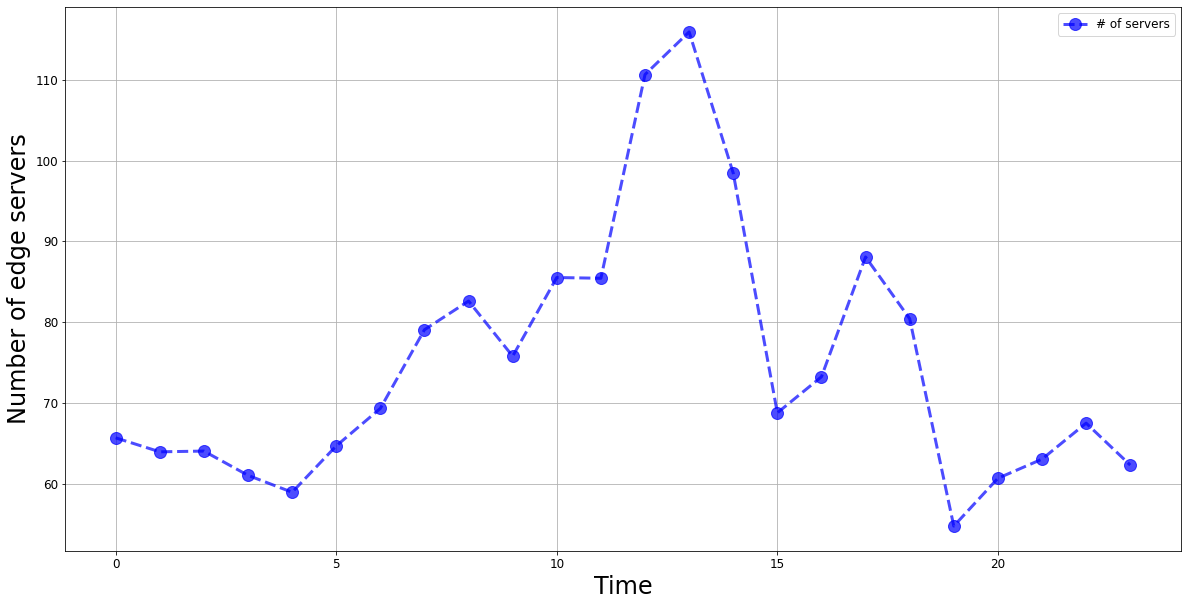

In [156]:
#CJS 24hr
fig, ax = plt.subplots(figsize=(20, 10))
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(accumulation[0], accumulation[1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='# of servers', alpha=0.7)


ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

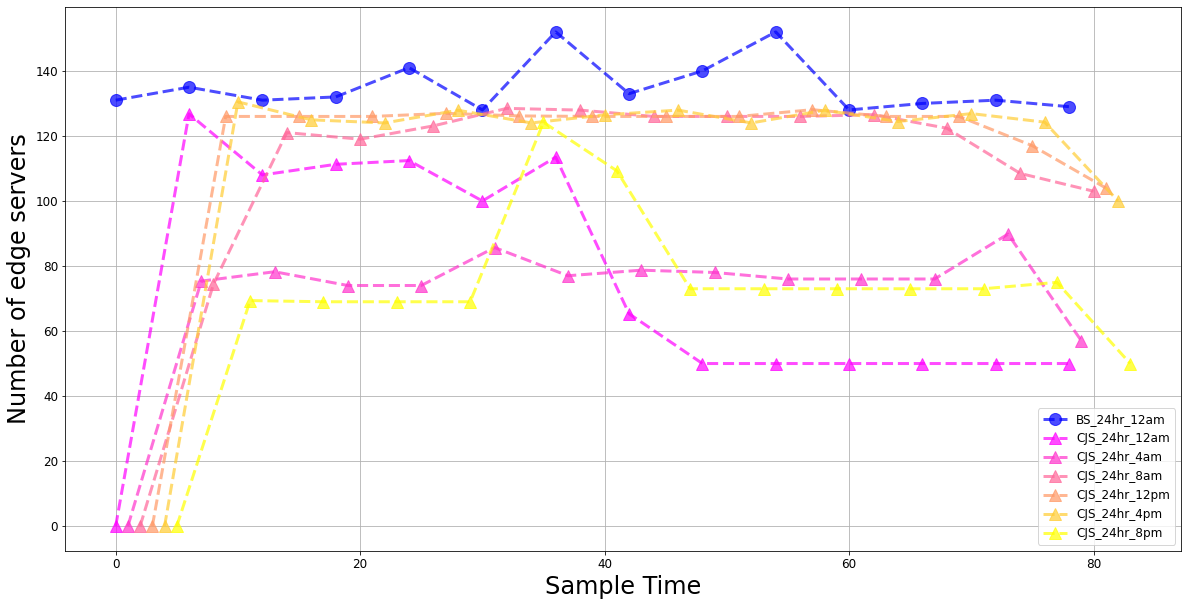

In [157]:
#CJS 24hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis1 = [6*d for d in range(14)]
x_axis2 = [6*d+1 for d in range(14)]
x_axis3 = [6*d+2 for d in range(14)]
x_axis4 = [6*d+3 for d in range(14)]
x_axis5 = [6*d+4 for d in range(14)]
x_axis6 = [6*d+5 for d in range(14)]
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)


plt.plot(x_axis1, estimate_N_24hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_24hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_24hr_4am', alpha=0.7)
plt.plot(x_axis3, estimate_N_24hr_8am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_24hr_8am', alpha=0.7)
plt.plot(x_axis4, estimate_N_24hr_12pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_24hr_12pm', alpha=0.7)
plt.plot(x_axis5, estimate_N_24hr_4pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_24hr_4pm', alpha=0.7)
plt.plot(x_axis6, estimate_N_24hr_8pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_24hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

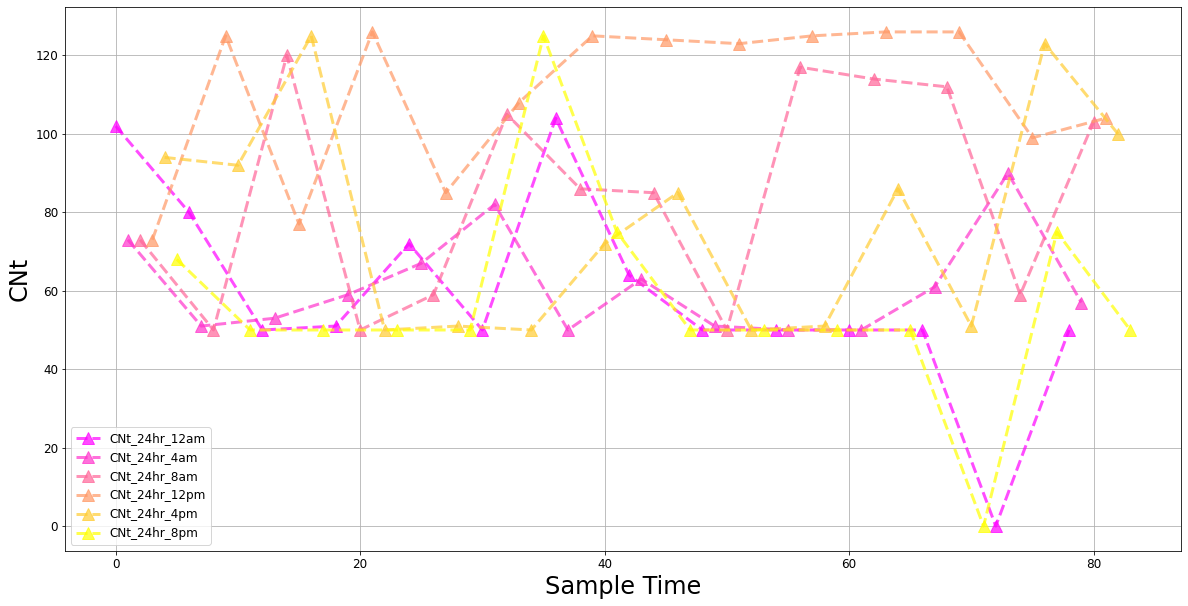

In [158]:
#CJS 24hr CNt
fig, ax = plt.subplots(figsize=(20, 10))
x_axis1 = [6*d for d in range(14)]
x_axis2 = [6*d+1 for d in range(14)]
x_axis3 = [6*d+2 for d in range(14)]
x_axis4 = [6*d+3 for d in range(14)]
x_axis5 = [6*d+4 for d in range(14)]
x_axis6 = [6*d+5 for d in range(14)]
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('CNt', fontsize=24)

plt.plot(x_axis1, CNt_24hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CNt_24hr_12am', alpha=0.7)
plt.plot(x_axis2, CNt_24hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CNt_24hr_4am', alpha=0.7)
plt.plot(x_axis3, CNt_24hr_8am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CNt_24hr_8am', alpha=0.7)
plt.plot(x_axis4, CNt_24hr_12pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CNt_24hr_12pm', alpha=0.7)
plt.plot(x_axis5, CNt_24hr_4pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CNt_24hr_4pm', alpha=0.7)
plt.plot(x_axis6, CNt_24hr_8pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CNt_24hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

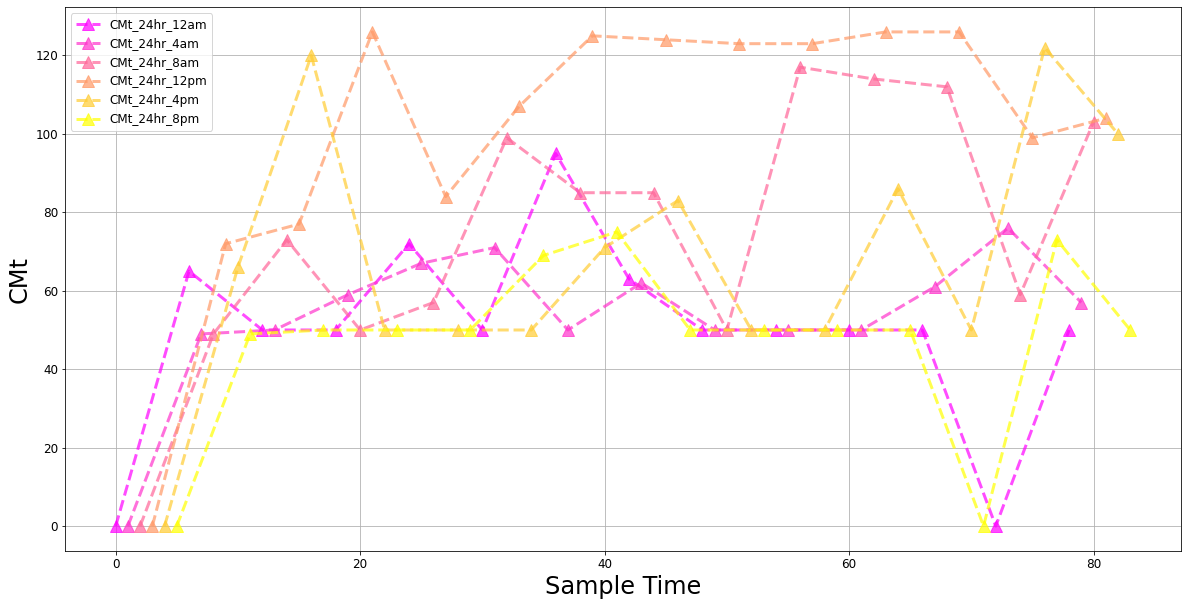

In [159]:
#CJS 24hr CMt
fig, ax = plt.subplots(figsize=(20, 10))
x_axis1 = [6*d for d in range(14)]
x_axis2 = [6*d+1 for d in range(14)]
x_axis3 = [6*d+2 for d in range(14)]
x_axis4 = [6*d+3 for d in range(14)]
x_axis5 = [6*d+4 for d in range(14)]
x_axis6 = [6*d+5 for d in range(14)]
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('CMt', fontsize=24)

plt.plot(x_axis1, CMt_24hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CMt_24hr_12am', alpha=0.7)
plt.plot(x_axis2, CMt_24hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CMt_24hr_4am', alpha=0.7)
plt.plot(x_axis3, CMt_24hr_8am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CMt_24hr_8am', alpha=0.7)
plt.plot(x_axis4, CMt_24hr_12pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CMt_24hr_12pm', alpha=0.7)
plt.plot(x_axis5, CMt_24hr_4pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CMt_24hr_4pm', alpha=0.7)
plt.plot(x_axis6, CMt_24hr_8pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CMt_24hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

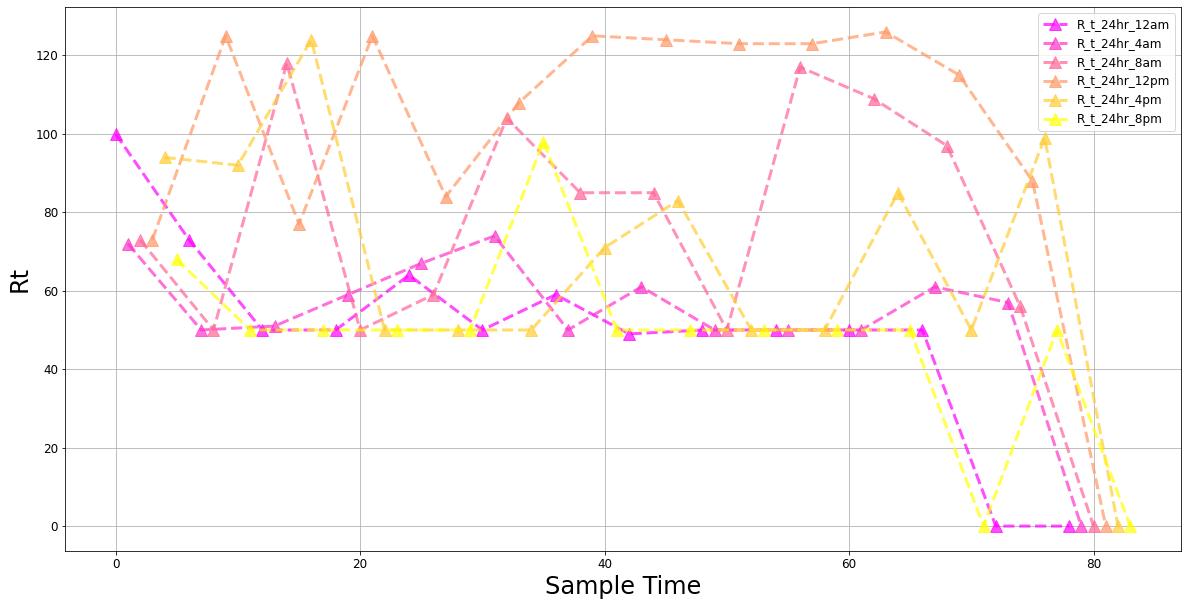

In [160]:
#CJS 24hr R_t
fig, ax = plt.subplots(figsize=(20, 10))
x_axis1 = [6*d for d in range(14)]
x_axis2 = [6*d+1 for d in range(14)]
x_axis3 = [6*d+2 for d in range(14)]
x_axis4 = [6*d+3 for d in range(14)]
x_axis5 = [6*d+4 for d in range(14)]
x_axis6 = [6*d+5 for d in range(14)]
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Rt', fontsize=24)

plt.plot(x_axis1, R_t_24hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='R_t_24hr_12am', alpha=0.7)
plt.plot(x_axis2, R_t_24hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='R_t_24hr_4am', alpha=0.7)
plt.plot(x_axis3, R_t_24hr_8am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='R_t_24hr_8am', alpha=0.7)
plt.plot(x_axis4, R_t_24hr_12pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='R_t_24hr_12pm', alpha=0.7)
plt.plot(x_axis5, R_t_24hr_4pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='R_t_24hr_4pm', alpha=0.7)
plt.plot(x_axis6, R_t_24hr_8pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='R_t_24hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

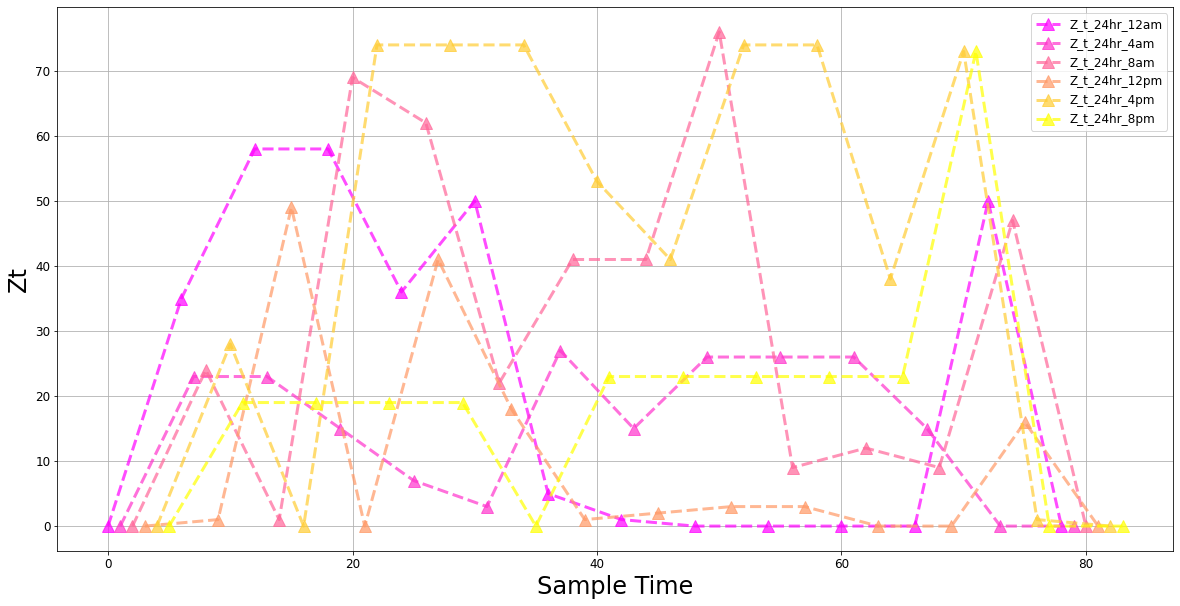

In [161]:
#CJS 24hr Z_t
fig, ax = plt.subplots(figsize=(20, 10))
x_axis1 = [6*d for d in range(14)]
x_axis2 = [6*d+1 for d in range(14)]
x_axis3 = [6*d+2 for d in range(14)]
x_axis4 = [6*d+3 for d in range(14)]
x_axis5 = [6*d+4 for d in range(14)]
x_axis6 = [6*d+5 for d in range(14)]
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Zt', fontsize=24)

plt.plot(x_axis1, Z_t_24hr_12am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='Z_t_24hr_12am', alpha=0.7)
plt.plot(x_axis2, Z_t_24hr_4am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='Z_t_24hr_4am', alpha=0.7)
plt.plot(x_axis3, Z_t_24hr_8am, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='Z_t_24hr_8am', alpha=0.7)
plt.plot(x_axis4, Z_t_24hr_12pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='Z_t_24hr_12pm', alpha=0.7)
plt.plot(x_axis5, Z_t_24hr_4pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='Z_t_24hr_4pm', alpha=0.7)
plt.plot(x_axis6, Z_t_24hr_8pm, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='Z_t_24hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

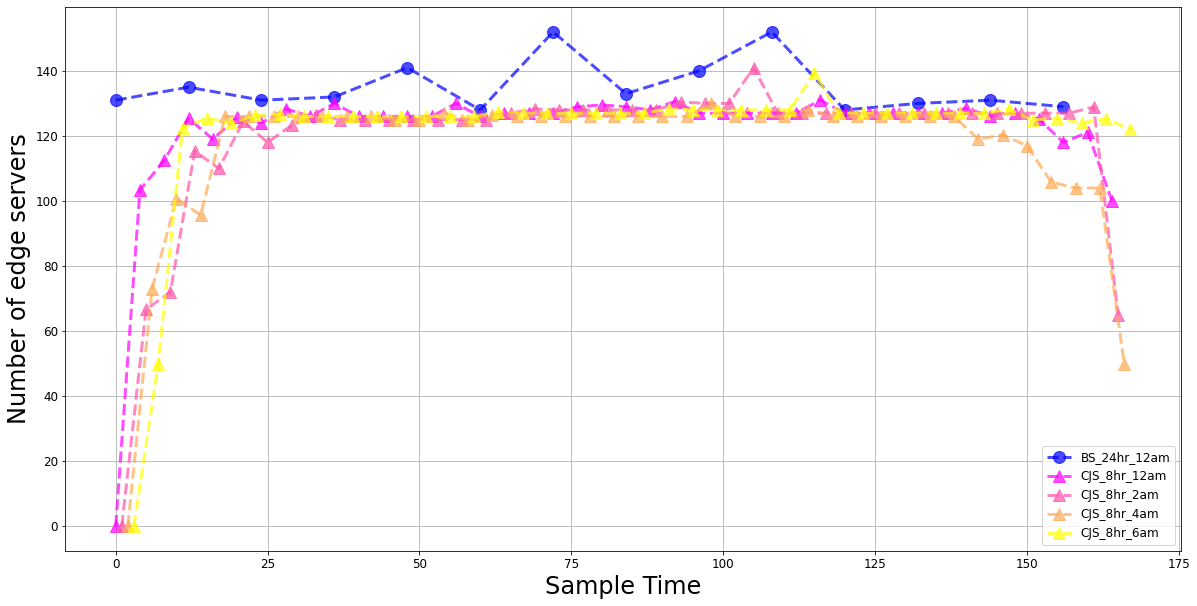

In [162]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [12*d for d in range(14)]
x_axis1 = [4*d for d in range(14*3)]
x_axis2 = [4*d+1 for d in range(14*3)]
x_axis3 = [4*d+2 for d in range(14*3)]
x_axis4 = [4*d+3 for d in range(14*3)]
color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_2am', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_4am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_4am', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_6am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_6am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

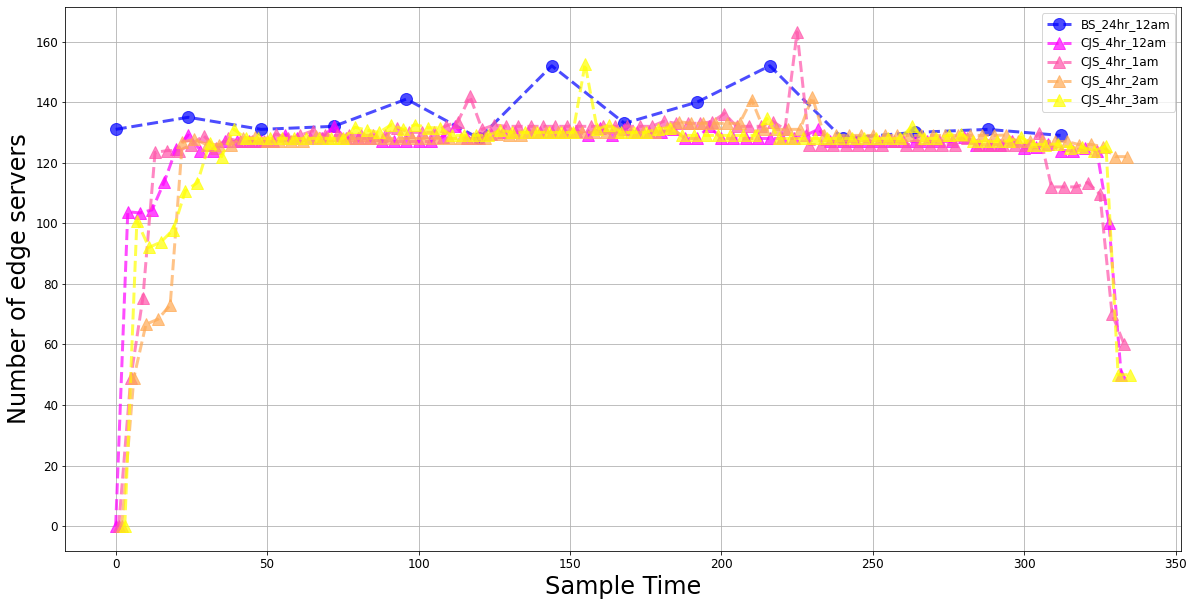

In [163]:
#CJS 4hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [24*d for d in range(14)]
x_axis1 = [4*d for d in range(14*6)]
x_axis2 = [4*d+1 for d in range(14*6)]
x_axis3 = [4*d+2 for d in range(14*6)]
x_axis4 = [4*d+3 for d in range(14*6)]
color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_1am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_1am', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_2am', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_3am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_3am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

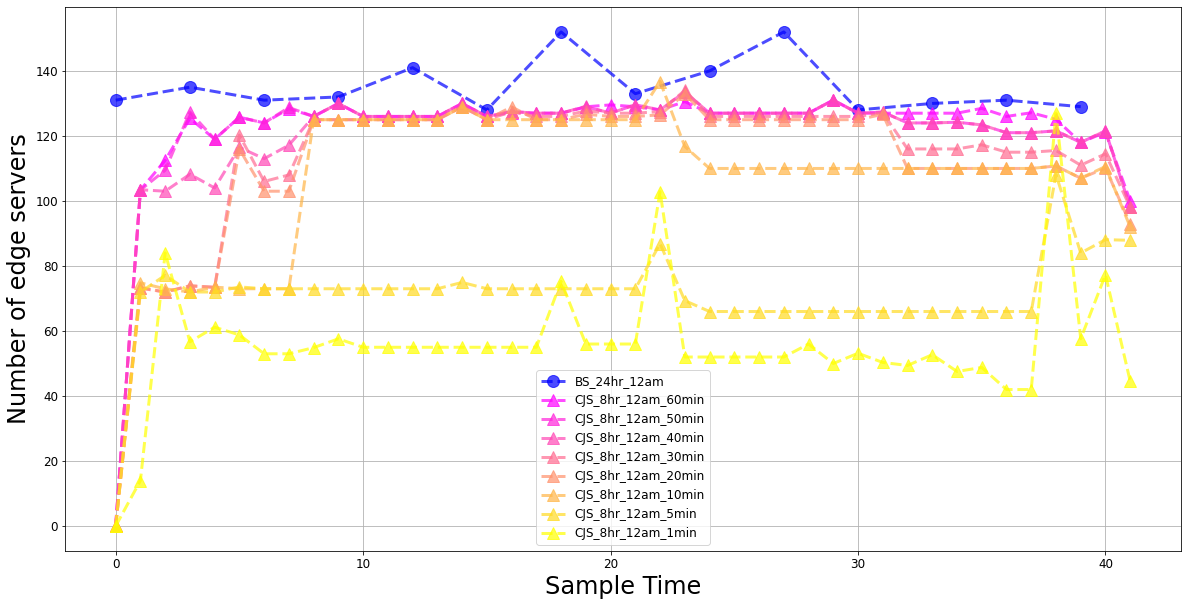

In [164]:
#CJS 8hr 12am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_12am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_12am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_12am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_12am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_12am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_12am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_12am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_12am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

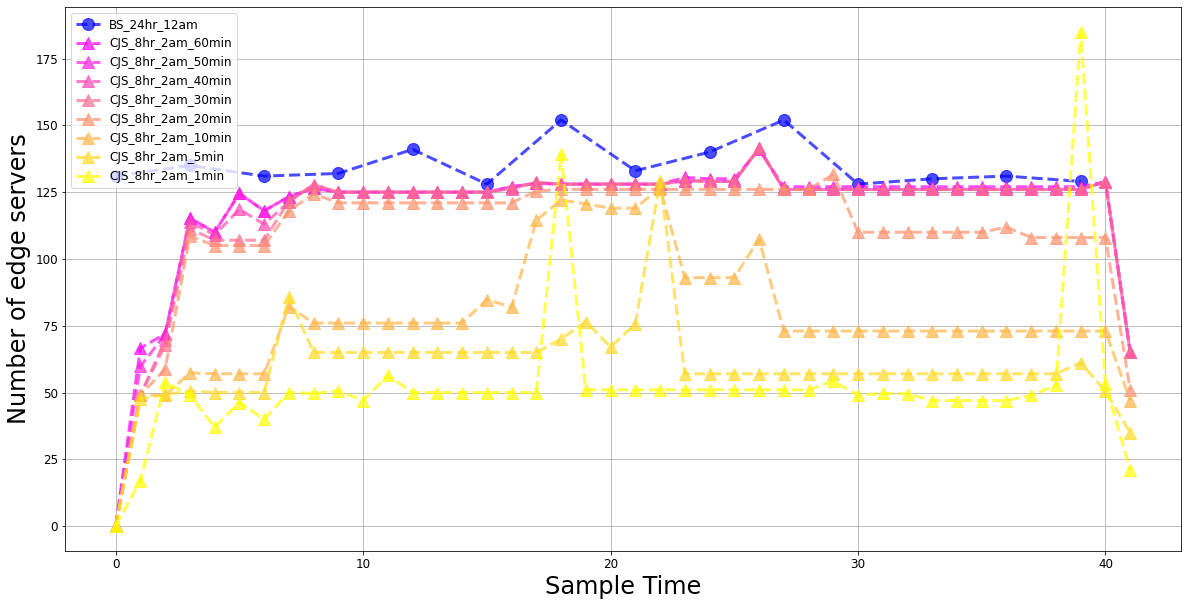

In [165]:
#CJS 8hr 2am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_2am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_2am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_2am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_2am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_2am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_2am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_2am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_2am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

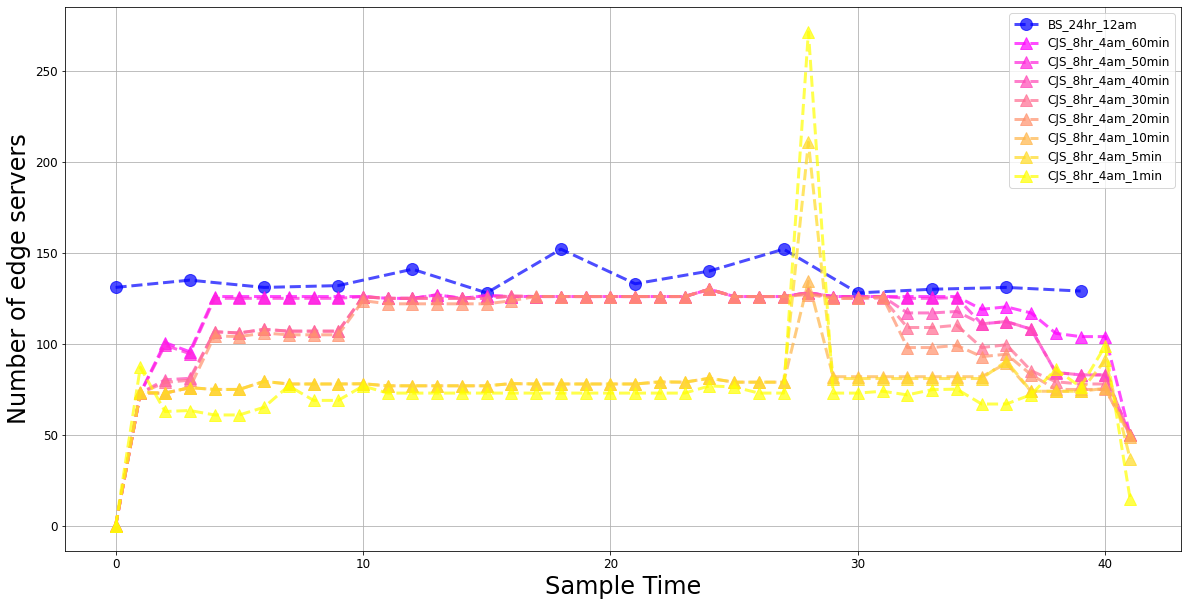

In [166]:
#CJS 8hr 4am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_4am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_4am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_4am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_4am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_4am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_4am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_4am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_4am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_4am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

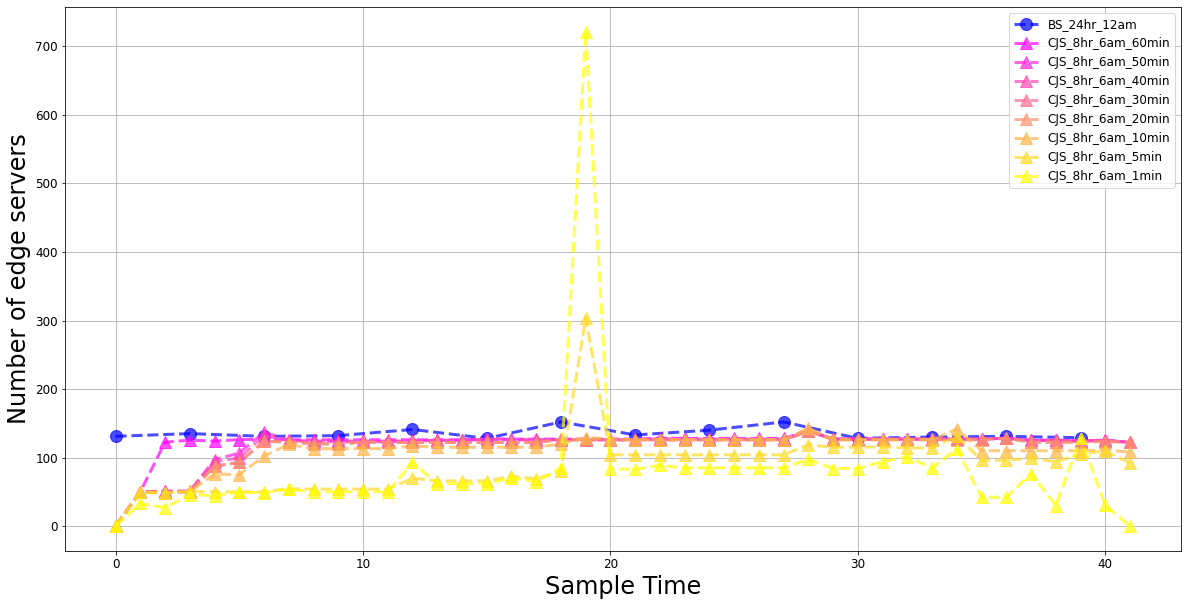

In [167]:
#CJS 8hr 6am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_6am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_6am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_6am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_6am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_6am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_6am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_6am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_6am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_6am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

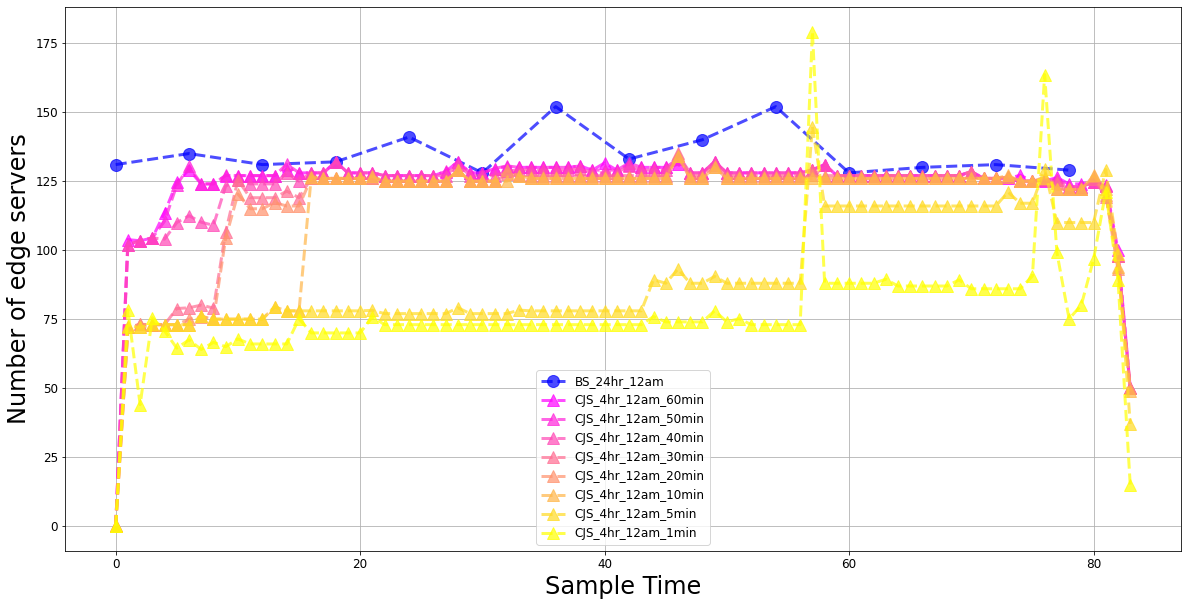

In [168]:
#CJS 4hr 12am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_12am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_12am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_12am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_12am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_12am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_12am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_12am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_12am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

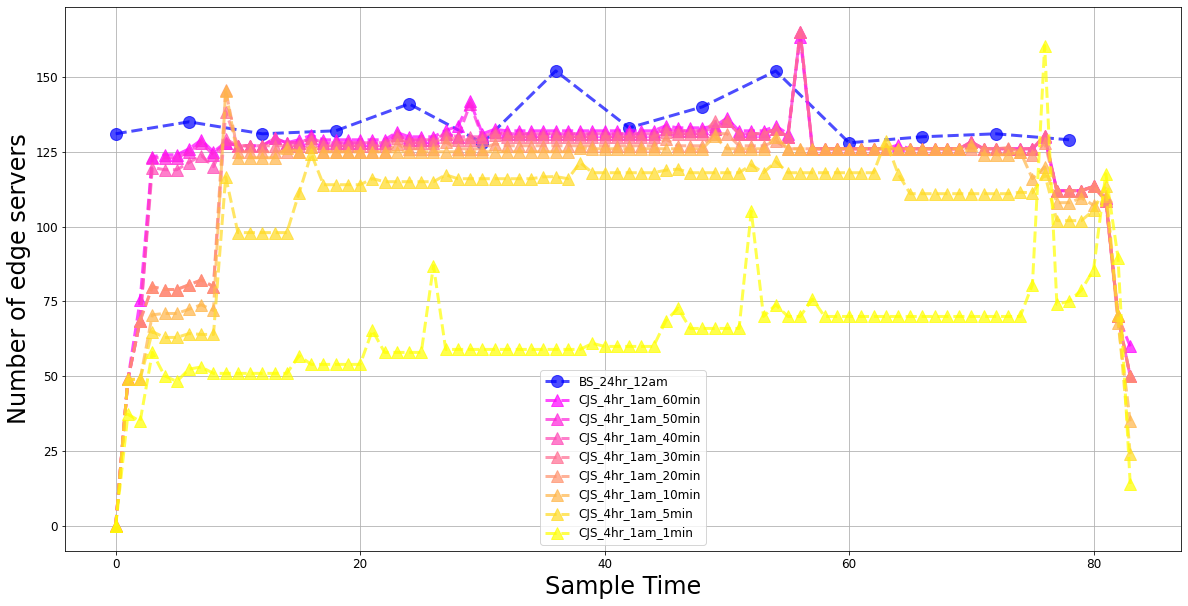

In [169]:
#CJS 4hr 1am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_1am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_1am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_1am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_1am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_1am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_1am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_1am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_1am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_1am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

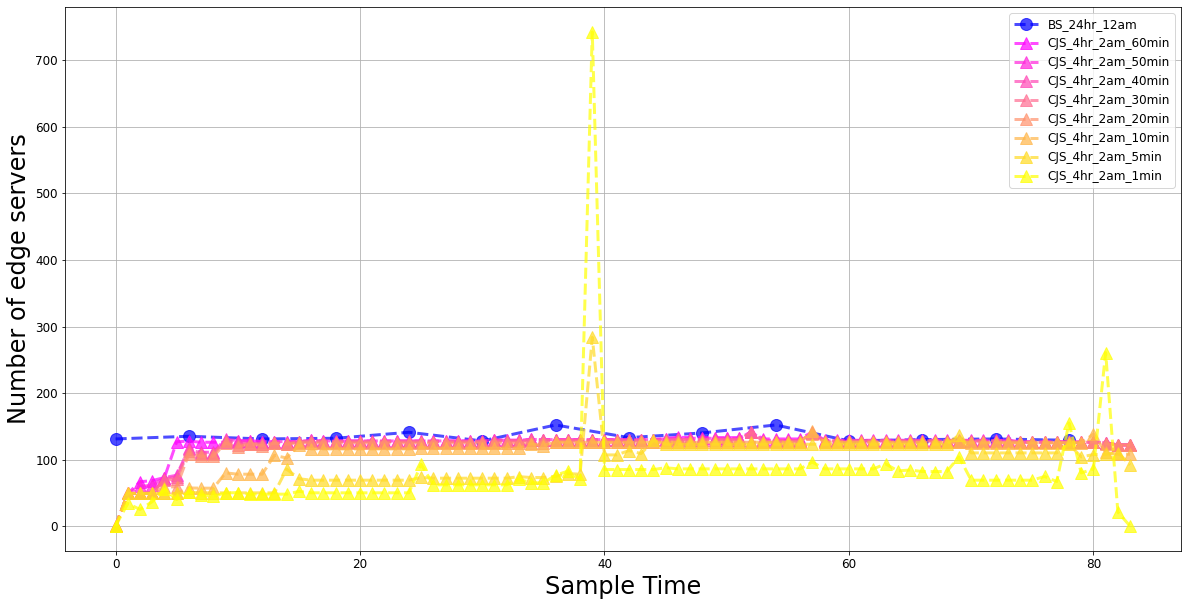

In [170]:
#CJS 4hr 2am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_2am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_2am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_2am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_2am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_2am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_2am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_2am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_2am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

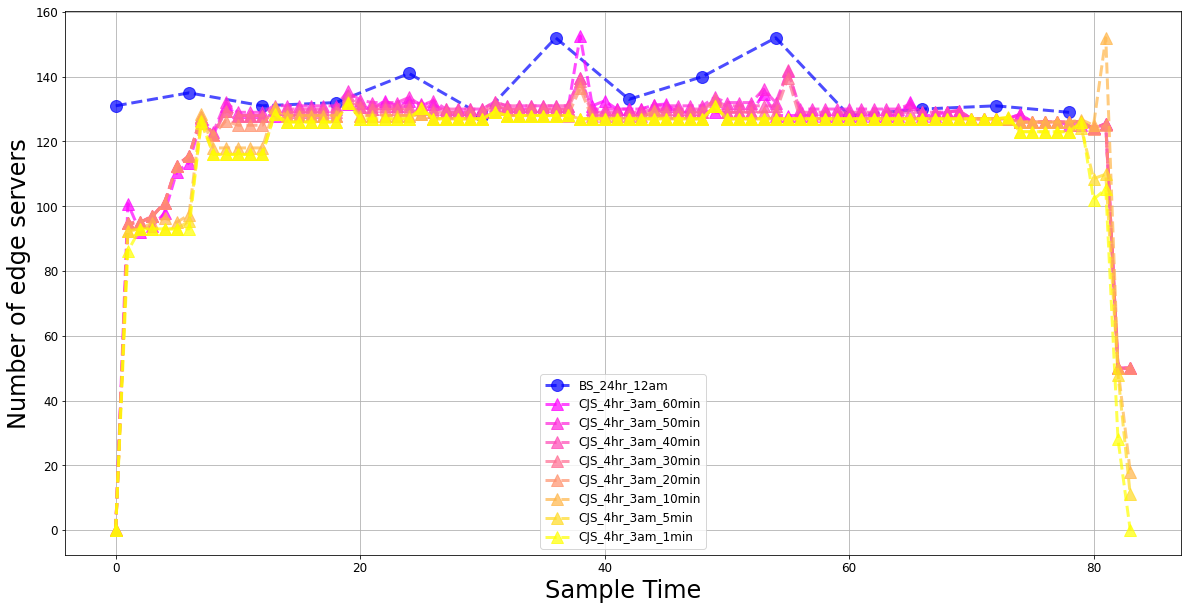

In [171]:
#CJS 4hr 3am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_3am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_3am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_3am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_3am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_3am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_3am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_3am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_3am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_3am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()